# Comparing Supervised Learned Approaches for Branch & Bound Strong Branching Approximation

<center>
Elena Ferro

Student ID 2166466

`elena.ferro.7@studenti.unipd.it`
</center>

## Problem statement
This section of the notebook aims at summarizing the high-level idea of this project; an in-depth introduction with theoretical background is given in the attached report.

In the context of Operational Research, MILP problems are often solved with the **Branch and Bound (B&B)** algorithm. Its efficiency mostly comes down to the performance of its branching strategy, that is, how at each node of the B&B tree the variable to branch on is chosen. **Strong Branching (SB)** is known to be the most effective strategy for reducing tree size, but it is computationally very expensive.

This project aims at reproducing and extending the experiment described by Alvarez et al. in [_A Supervised Machine Learning Approach to
Variable Branching in Branch-And-Bound_](https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=f35ba2bbc87dd31ae0a89d3ed9538fec9d15b4f0), who proposed the use of machine learning to approximate SB score and overcome this burden.

The proposed approach involves three main phases:
1. solving a set of MILP problems using the SB strategy and extracting features at each B&B tree node, along with the metric that determined the branching decision;
1. using this dataset to train a regressor that mimics SB decisions, aiming for accurate approximations without the computational overhead;
1. employing the trained regressor to solve benchmark problems and comparing its performance against SB and other branching strategies.

Hence, given a set of features the goal is to have a regressor which is able to predict a real-valued scores.

The goal is not to find the best overall model, but rather the one which is able to **better trade-off** the **correctness** of the prediction with the **time it takes to compute it**. In this context, a slow but highly accurate model would not be much more useful than actually computing SB scores, while a fast but imprecise one would yield fairly large B&B trees and thus influence negatively the solver's performance. Since these trees can have infinitely many nodes and in each of them the model will be asked to predict scores for every fractional variable, even a small increase in the prediction time can have a significant impact on the solution time.


The common standard form for MILP optimization problems is defined as follows:

$$\min z=c^{T}x$$
$$\text{s.t.}$$
$$Ax\le b$$
$$x_{i}\in\mathbb{Z}\forall i\in I$$
$$x_{i}\in\mathbb{R}_{+}\forall i\in C$$

In this formulation:
* $c\in\mathbb{R}^{n}$ is the cost vector;
* $A\in\mathbb{R}^{m\times n}$ is the coefficient matrix;
* $b\in\mathbb{R}^{m}$ is the right-hand side vector;
* $x$ is the vector of decision variable;
* $I$ is the set of indices for integer variables;
* $C$ is the set of indices for continuous variables.

The problems used in this project fall into several categories:
- randomly generated Bin Packing (BP) instances;
- randomly generated Set Cover (SC) instances;
- the smallest problem from the MIPLIB set, a standard benchmark for MILP problems;
- a subset of MKNSC problems (combining Multiple Knapsack Problem and SC constraints) from the original experiment;
- a subset of BPEQ problems (combining BP and Equality constraints) from the original experiment;
- a subset of BPSC problems (combining BP and SC constraints) from the original experiment.

Below is a table containing a summary of problem characteristics.

| Category | Tot. of problems | Test instances | Train instances | Avg. nr. of variables | Avg. nr. of constraints | Avg. nodes | Avg. solution time (s) |
|---|---|---|---|---|---|---|---|
| bpeq | 7 | 5 | 2 | 195 | 108 | 20978 | 2830.65 |
| bpsc | 1 | 1 | 0 | 112 | 97 | 42813 | 7873.79 |
| miplib | 1 | 1 | 0 | 201 | 133 | 50 | 35.30 |
| mknsc | 5 | 3 | 2 | 196 | 130 | 37378 | 3874.97 |
| randomBP | 91 | 22 | 69 | 57 | 15 | 230 | 5.93 |
| randomSC | 103 | 20 | 83 | 88 | 88 | 32 | 7.97 |

In [114]:
import pandas as pd
import numpy as np

seed = 0

In [115]:
!pip install pyscipopt seaborn imodels lightgbm pymoo # install dependencies

## Features
A total of 38 features were computed, categorized into static, dynamic, and dynamic optimization features. They were designed to be independent of problem size and irrelevant changes like reordering, with size-dependent quantities normalized to represent relative values.

### Static features


| Feature | Description |
|---|---|
| $sign \{c_{i}\}$ | Sign of the cost coefficient $c_i$. |
| $|c_{i}|/\sum_{j:c_{j}\ge0}|c_{j}|$ | Normalized absolute cost coefficient for non-negative $c_j$. |
| $|c_{i}|/\sum_{j:c_{j}<0}|c_{j}|$ | Normalized absolute cost coefficient for negative $c_j$. |
| $M_{j}^{1+}(i)=A_{ji}/|b_{j}|,\forall j$ such that $b_{j}\ge0$ | Measures variable $i$'s contribution to constraint violations for non-negative $b_j$. |
| $M_{j}^{1-}(i)=A_{ji}/|b_{j}|,\forall$ Vj such that $b_{j}<0$ | Measures variable $i$'s contribution to constraint violations for negative $b_j$. |
| $\min,\max\{M_{j}^{1+}(i)\},\min/\max\{M_{j}^{1-}(i)\}$ | Minimum and maximum values of $M_j^{1+}(i)$ and $M_j^{1-}(i)$. |
| $\min,\max\{M_{j}^{2+}(i)\},\min/\max\{M_{j}^{2-}(i)\}$ | Minimum and maximum values of $M_j^{2+}(i)$ and $M_j^{2-}(i)$. |
| $\min,\max\{M_{j}^{3++}(i)\},\min/\max\{M_{j}^{3+-}(i)\}$ | Minimum and maximum values of $M_j^{3++}(i)$ and $M_j^{3+-}(i)$. |
| $\min,\max\{M_{j}^{3-+}(i)\},\min/\max\{M_{j}^{3--}(i)\}$ | Minimum and maximum values of $M_j^{3-+}(i)$ and $M_j^{3--}(i)$. |

### Dynamic features

| Feature | Description |
|---|---|
| Up and down fractionalities of i | Fractional part of variable $i$ in both up and down directions. |
| Sensitivity range of the objective function coefficient of $i/|c_{i}|$ | Normalized sensitivity range of the objective function coefficient for variable $i$. |
| * Node depth of the current node / total number of nodes in the tree | Normalized depth of the current node in the B&B tree. |
| * Number of fixed variables at the current node / total number of variables | Normalized count of fixed variables at the current node. |
| $*min\{x_{i}-\lfloor x_{i}\rfloor,\lceil x_{i}\rceil-x_{i}\}$ | Minimum distance of $x_i$ to the nearest integer. |


### Dynamic optimization features

| Feature | Description |
|---|---|
| min, max, mean, std, quartiles objective increases / obj. value at current node | Statistical measures (min, max, mean, standard deviation, quartiles) of objective increases, normalized by the objective value at the current node. |
| up, down pseudocosts for variable $i/obj$. value at root node | Pseudocosts for variable $i$ (up and down branches), normalized by the objective value at the root node. |
| times i has been chosen as branching variable / total number of branchings | Normalized count of how many times variable $i$ has been chosen as a branching variable. |

Below are some utility functions extracting features from `A`, `b` and `c`.


In [116]:
from math import ceil, floor
import numpy as np


class Params:
    def __init__(self, var_idx: int, x_i: float, node_depth: int, nr_variables: int, curr_obj: float,
                 n_branches_by_var: int, n_nodes: int, downfrac: float, allowed_increase: float,
                 allowed_decrease: float,
                 upfrac: float, objective_increases: list, nr_fixed_variables: int, root_obj_val: float,
                 up_pseudo_cost: float, down_pseudo_cost: float, sense: str):
        self.var_idx = var_idx
        self.x_i = x_i
        self.node_depth = node_depth
        self.nr_variables = nr_variables
        self.nr_fixed_variables = nr_fixed_variables
        self.curr_obj = curr_obj
        self.n_branches_by_var = n_branches_by_var
        self.n_nodes = n_nodes
        self.down_frac = downfrac
        self.up_frac = upfrac
        self.allowed_decrease = allowed_decrease
        self.allowed_increase = allowed_increase
        self.objective_increases = objective_increases
        self.root_obj_val = root_obj_val
        self.up_pseudo_cost = up_pseudo_cost
        self.down_pseudo_cost = down_pseudo_cost
        self.sense = sense


def __static_feat(i: int, A: np.ndarray, b: np.ndarray, c: np.ndarray):
    features = {}
    # 1st class
    # sign{c_i}
    c_i = c[i]
    features['sign'] = np.sign(c_i)

    # |c_i| / sum_{k: c_k >= 0} |c_k|
    pos_sum = np.sum(np.abs(c[c >= 0]))
    # |c_i| / sum_{k: c_k < 0} |c_k|
    neg_sum = np.sum(np.abs(c[c < 0]))

    features['c_i/sum_pos'] = abs(c_i) / pos_sum if pos_sum != 0 else 0
    features['c_i/sum_neg'] = abs(c_i) / neg_sum if neg_sum != 0 else 0

    # 2nd class
    # m_j^{+1}(i) = A_{ji}/|b_j|, forall j s.t. b_j >= 0
    M1_pos = []
    # m_j^{-1}(i) = A_{ji}/|b_j|, forall j s.t. b_j < 0
    M1_neg = []
    for j in range(A.shape[0]):
        a_ji = A[j, i]
        if b[j] >= 0:
            M1_pos.append(a_ji / abs(b[j]) if b[j] != 0 else 0)
        else:
            M1_neg.append(a_ji / abs(b[j]))

    features['M1_pos_min'] = np.min(M1_pos) if M1_pos else 0
    features['M1_pos_max'] = np.max(M1_pos) if M1_pos else 0
    features['M1_neg_min'] = np.min(M1_neg) if M1_neg else 0
    features['M1_neg_max'] = np.max(M1_neg) if M1_neg else 0

    # m_j^{2+} (i) = |c_i|/|A_{ji}| forall j s.t. c_i >= 0
    M2_pos = []
    # m_j^{2-} (i) = |c_i|/|A_{ji}| forall j s.t. c_i < 0
    M2_neg = []
    for j in range(A.shape[0]):
        if c[i] >= 0:
            M2_pos.append(abs(c_i) / abs(A[j, i]) if A[j, i] != 0 else 0)
        else:
            M2_neg.append(abs(c_i) / abs(A[j, i]) if A[j, i] != 0 else 0)

    features['M2_pos_min'] = np.min(M2_pos) if M2_pos else 0
    features['M2_pos_max'] = np.max(M2_pos) if M2_pos else 0
    features['M2_neg_min'] = np.min(M2_neg) if M2_neg else 0
    features['M2_neg_max'] = np.max(M2_neg) if M2_neg else 0

    M3_pp = []
    M3_pm = []
    M3_mp = []
    M3_mm = []

    for j in range(A.shape[0]):
        pos_sum = np.sum(np.abs(A[j, A[j] >= 0]))
        neg_sum = np.sum(np.abs(A[j, A[j] < 0]))

        a_ji = abs(A[j, i])
        if A[j, i] >= 0:
            M3_pp.append(a_ji / pos_sum if pos_sum != 0 else 0)
            M3_pm.append(a_ji / neg_sum if neg_sum != 0 else 0)
        else:
            M3_mp.append(a_ji / pos_sum if pos_sum != 0 else 0)
            M3_mm.append(a_ji / neg_sum if neg_sum != 0 else 0)

    features['M3_pp_min'] = np.min(M3_pp) if M3_pp else 0
    features['M3_pp_max'] = np.max(M3_pp) if M3_pp else 0
    features['M3_pm_min'] = np.min(M3_pm) if M3_pm else 0
    features['M3_pm_max'] = np.max(M3_pm) if M3_pm else 0
    features['M3_mp_min'] = np.min(M3_mp) if M3_mp else 0
    features['M3_mp_max'] = np.max(M3_mp) if M3_mp else 0
    features['M3_mm_min'] = np.min(M3_mm) if M3_mm else 0
    features['M3_mm_max'] = np.max(M3_mm) if M3_mm else 0

    return features


def __dynamic_feat(params: Params, c: np.ndarray):
    features = {}
    features['depth'] = params.node_depth / params.nr_variables
    features['fixed_vars'] = params.nr_fixed_variables / params.nr_variables

    features['min_xi'] = min(params.x_i - floor(params.x_i), ceil(params.x_i) - params.x_i)

    # sensitivity ranges
    c_i = c[params.var_idx]
    features['sign_allowed_decrease'] = np.sign(params.allowed_decrease)
    features['sign_allowed_increase'] = np.sign(params.allowed_increase)

    normalized_decrease = np.abs((c_i - params.allowed_decrease) / c_i) if c_i != 0 else 0
    normalized_increase = np.abs((params.allowed_increase - c_i) / c_i) if c_i != 0 else 0

    features['log_allowed_increase'] = np.log(normalized_increase) if normalized_increase != 0 else 0
    features['log_allowed_decrease'] = np.log(normalized_decrease) if normalized_decrease != 0 else 0

    features['down_frac'] = params.down_frac
    features['up_frac'] = params.up_frac

    return features


def __dynamic_opt_feat(params: Params):
    features = {}
    features['branching_ratio'] = params.n_branches_by_var / params.n_nodes

    features['min_obj_increase'] = np.min(params.objective_increases) if params.objective_increases else 0
    features['max_obj_increase'] = np.max(params.objective_increases) if params.objective_increases else 0
    features['avg_obj_increase'] = np.mean(params.objective_increases) if params.objective_increases else 0
    features['std_obj_increase'] = np.std(params.objective_increases) if params.objective_increases else 0

    # quartiles
    features['quartile_25_obj_increase'] = np.percentile(params.objective_increases,
                                                         25) if params.objective_increases else 0
    features['quartile_50_obj_increase'] = np.percentile(params.objective_increases,
                                                         50) if params.objective_increases else 0
    features['quartile_75_obj_increase'] = np.percentile(params.objective_increases,
                                                         75) if params.objective_increases else 0

    # divide all by curr_obj
    features['min_obj_increase'] /= params.curr_obj if params.curr_obj != 0 else 0
    features['max_obj_increase'] /= params.curr_obj if params.curr_obj != 0 else 0
    features['avg_obj_increase'] /= params.curr_obj if params.curr_obj != 0 else 0
    features['std_obj_increase'] /= params.curr_obj if params.curr_obj != 0 else 0
    features['quartile_25_obj_increase'] /= params.curr_obj if params.curr_obj != 0 else 0
    features['quartile_50_obj_increase'] /= params.curr_obj if params.curr_obj != 0 else 0
    features['quartile_75_obj_increase'] /= params.curr_obj if params.curr_obj != 0 else 0

    features['up_pseudocost'] = params.up_pseudo_cost / params.root_obj_val if params.root_obj_val != 0 else 0
    features['down_pseudocost'] = params.down_pseudo_cost / params.root_obj_val if params.root_obj_val != 0 else 0
    return features


def compute_features(params: Params, A: np.ndarray, b: np.ndarray, c: np.ndarray):
    static = __static_feat(params.var_idx, A, b, c)
    dynamic = __dynamic_feat(params, c)
    dynamic_opt = __dynamic_opt_feat(params)

    return {**static, **dynamic, **dynamic_opt}


The SCIP solver was employed; it provides APIs that allow users to define custom branching callbacks. These are automatically invoked when added to a model, enabling the interception of the B&B algorithm's execution to extract desired information.

The `StrongBranching` below implements the SB strategy and extracts scores and features which are stored inside `dataset`. Fields such as `n_branches_by_var` or `root_obj_val` are support variables needed for the feature computation.

In [117]:
from pyscipopt import Model, Branchrule, Variable
from pyscipopt import SCIP_RESULT
import numpy as np
from collections import defaultdict
import pandas as pd

class StrongBranching(Branchrule):
    def __init__(self, model, A, b, c, logged, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.model: Model = model
        self.dataset = pd.DataFrame()
        self.A = A
        self.b = b
        self.c = c
        self.logged = logged
        self.n_branches_by_var = defaultdict(int)
        self.objective_increases_by_var = defaultdict(list)
        self.down_pseudo_costs_history = defaultdict(float)
        self.up_pseudo_costs_history = defaultdict(float)
        self.root_obj_val = model.infinity() if model.getObjectiveSense() == "minimize" else -model.infinity()

    def branchexeclp(self, _):
        branch_cands, _, branch_cand_fracs, _, npriocands, _ = self.model.getLPBranchCands()

        # Initialise scores for each variable
        scores = [-self.model.infinity() for _ in range(npriocands)]
        down_bounds = [None for _ in range(npriocands)]
        up_bounds = [None for _ in range(npriocands)]

        # Initialise placeholder values
        num_nodes = self.model.getNNodes()
        lpobjval = self.model.getLPObjVal()
        lperror = False
        best_cand_idx = 0

        # Start strong branching and iterate over the branching candidates
        self.model.startStrongbranch()
        for i in range(npriocands):

            # Check the case that the variable has already been strong branched on at this node.
            # This case occurs when events happen in the node that should be handled immediately.
            # When processing the node again (because the event did not remove it), there's no need to duplicate work.
            if self.model.getVarStrongbranchNode(branch_cands[i]) == num_nodes:
                down, up, downvalid, upvalid, _, lastlpobjval = self.model.getVarStrongbranchLast(branch_cands[i])
                if downvalid:
                    down_bounds[i] = down
                if upvalid:
                    up_bounds[i] = up
                downgain = max([down - lastlpobjval, 0])
                upgain = max([up - lastlpobjval, 0])
                scores[i] = self.model.getBranchScoreMultiple(branch_cands[i], [downgain, upgain])
                continue

            # Strong branch
            down, up, downvalid, upvalid, downinf, upinf, downconflict, upconflict, lperror = self.model.getVarStrongbranch(
                branch_cands[i], 200, idempotent=False)

            # In the case of an LP error handle appropriately (for this example we just break the loop)
            if lperror:
                break

            # In the case of both infeasible sub-problems cutoff the node
            if downinf and upinf:
                return {"result": SCIP_RESULT.CUTOFF}

            # Calculate the gains for each up and down node that strong branching explored
            if not downinf and downvalid:
                down_bounds[i] = down
                downgain = max([down - lpobjval, 0])
            else:
                downgain = 0
            if not upinf and upvalid:
                up_bounds[i] = up
                upgain = max([up - lpobjval, 0])
            else:
                upgain = 0

            # Update the pseudo-costs
            lpsol = branch_cands[i].getLPSol()
            if not downinf and downvalid:
                self.model.updateVarPseudocost(branch_cands[i], -self.model.frac(lpsol), downgain, 1)
                self.down_pseudo_costs_history[branch_cands[i].name] = downgain / -self.model.frac(lpsol)
                self.objective_increases_by_var[branch_cands[i].name].append(downgain)
            if not upinf and upvalid:
                self.model.updateVarPseudocost(branch_cands[i], 1 - self.model.frac(lpsol), upgain, 1)
                self.up_pseudo_costs_history[branch_cands[i].name] = upgain / (1 - self.model.frac(lpsol))
                self.objective_increases_by_var[branch_cands[i].name].append(upgain)

            scores[i] = self.model.getBranchScoreMultiple(branch_cands[i], [downgain, upgain])

            if scores[i] > scores[best_cand_idx]:
                best_cand_idx = i

            self.n_branches_by_var[branch_cands[i].name] += 1
            features = self.extract_feats(branch_cand_fracs[i], branch_cands[i])
            curr_obj = self.model.getLPObjVal()
            features['score'] = scores[i] / np.abs(curr_obj) if curr_obj != 0 else 0
            row = pd.DataFrame.from_dict(features, orient='index').T
            self.dataset = pd.concat([self.dataset, row], ignore_index=True)

        # End strong branching
        self.model.endStrongbranch()

        # In the case of an LP error
        if lperror:
            return {"result": SCIP_RESULT.DIDNOTRUN}

        down_child, _, up_child = self.model.branchVarVal(
            branch_cands[best_cand_idx], branch_cands[best_cand_idx].getLPSol())

        # Update the bounds of the down node and up node. Some cols might not exist due to pricing
        if self.model.allColsInLP():
            if down_child is not None and down_bounds[best_cand_idx] is not None:
                self.model.updateNodeLowerbound(down_child, down_bounds[best_cand_idx])
            if up_child is not None and up_bounds[best_cand_idx] is not None:
                self.model.updateNodeLowerbound(up_child, up_bounds[best_cand_idx])

        return {"result": SCIP_RESULT.BRANCHED}

    def n_fixed_vars(self):
        # from https://github.com/scipopt/PySCIPOpt/issues/347#issuecomment-602466658
        fixedvars = 0
        transvars = self.model.getVars(transformed=True)
        for var in transvars:
            if self.model.isFeasEQ(var.getLbLocal(), var.getUbLocal()):
                fixedvars += 1
        return fixedvars

    def get_sensitivity_range(self, var):
        # Get all variables in the LP
        all_vars = self.model.getVars(transformed=True)  # Get transformed vars for LP operations
        lp_cols_data = self.model.getLPColsData()
        lp_cols_map = {col.getLPPos(): col.getVar() for col in lp_cols_data}

        lp_basis_ind = self.model.getLPBasisInd()  # List of column indices in basis
        is_var_basic = False
        var_col = var.getCol()
        if var_col and var_col.getLPPos() != -1:  # Check if the variable is in the current LP formulation
            if var_col.getBasisStatus() == 'basic':
                is_var_basic = True

        obj_sense = self.model.getObjectiveSense()  # 'maximize' or 'minimize'

        if not is_var_basic:
            red_cost = self.model.getVarRedcost(var)
            current_obj_coeff = var.getObj()

            if obj_sense == 'maximize':
                allowable_increase = red_cost
                allowable_decrease = self.model.infinity()

                # Check for floating point issues: if red_cost is tiny negative, treat as 0
                if self.model.isLT(red_cost, 0):
                    allowable_increase = 0.0
            else:  # minimize
                allowable_increase = self.model.infinity()
                allowable_decrease = -red_cost
                # Check for floating point issues: if red_cost is tiny positive, treat as 0
                if self.model.isGT(red_cost, 0):
                    allowable_decrease = 0.0

            return current_obj_coeff - allowable_decrease, current_obj_coeff + allowable_increase

        else:
            allowable_increase = self.model.infinity()
            allowable_decrease = self.model.infinity()
            current_obj_coeff = var.getObj()

            # Find the row index of the basic variable 'var' in the basis
            # We need to find which basic variable in lp_basis_ind corresponds to 'var'
            basic_var_lp_pos = -1
            for i, col_idx in enumerate(lp_basis_ind):
                if col_idx >= 0:  # It's a column variable (not a slack/artificial)
                    bvar = lp_cols_map.get(col_idx)
                    if bvar and bvar.name == var.name:  # Match by name or some unique identifier
                        basic_var_lp_pos = i  # This is the row index in the basis
                        break

            if basic_var_lp_pos == -1:
                return None, None

            # Get the row from B^-1 A corresponding to the basic variable 'var'
            # This row contains the values (B^-1 A_j)_p for all non-basic columns j.
            # PySCIPOpt's getLPBInvARow returns a dense list where index corresponds to LP column index
            b_inv_a_row_for_var = self.model.getLPBInvARow(basic_var_lp_pos)

            # Iterate through all variables to find non-basic ones
            for non_basic_var in all_vars:
                non_basic_col = non_basic_var.getCol()

                # Ensure the non-basic variable is part of the LP and is indeed non-basic
                if (non_basic_col and non_basic_col.getLPPos() != -1 and
                        non_basic_col.getBasisStatus() in ['lower', 'upper', 'zero', 'free']):

                    nb_lp_pos = non_basic_col.getLPPos()
                    # Get the current reduced cost of the non-basic variable
                    original_red_cost_j = self.model.getVarRedcost(non_basic_var)

                    # This is the (B^-1 A_j)_p value, denoted as \bar{a}_{pj} in the explanation
                    a_bar_pj = b_inv_a_row_for_var[nb_lp_pos]

                    # Only consider non-zero a_bar_pj to avoid division by zero
                    if not self.model.isZero(a_bar_pj):
                        if obj_sense == 'maximize':
                            # New reduced cost: original_red_cost_j - Delta_c_k * a_bar_pj >= 0
                            # This is for maximization, so original_red_cost_j should be >= 0

                            # If a_bar_pj > 0: Delta_c_k <= original_red_cost_j / a_bar_pj
                            if self.model.isGT(a_bar_pj, 0):
                                ratio = original_red_cost_j / a_bar_pj
                                allowable_increase = min(allowable_increase, ratio)

                            # If a_bar_pj < 0: Delta_c_k >= original_red_cost_j / a_bar_pj
                            # This creates a lower bound for Delta_c_k (which is a negative value)
                            elif self.model.isLT(a_bar_pj, 0):
                                ratio = original_red_cost_j / a_bar_pj
                                allowable_decrease = min(allowable_decrease, -ratio)
                                allowable_decrease = min(allowable_decrease, -ratio)

                        else:  # minimize
                            if self.model.isGT(a_bar_pj, 0):
                                ratio = original_red_cost_j / a_bar_pj
                                allowable_decrease = min(allowable_decrease, ratio)
                            elif self.model.isLT(a_bar_pj, 0):
                                ratio = original_red_cost_j / a_bar_pj
                                allowable_increase = min(allowable_increase, -ratio)
                                allowable_increase = min(allowable_increase, -ratio)

            lower_bound = current_obj_coeff - allowable_decrease
            upper_bound = current_obj_coeff + allowable_increase

            return lower_bound, upper_bound

    def extract_feats(self, frac, var):
        allowable_increase, allowable_decrease = self.get_sensitivity_range(var)
        params = Params(
            var_idx=var.getCol().getLPPos(),
            x_i=var.getObj(),
            node_depth=self.model.getCurrentNode().getDepth(),
            nr_variables=self.model.getNVars(),
            curr_obj=self.model.getLPObjVal(),
            n_branches_by_var=self.n_branches_by_var[var.name],
            n_nodes=self.model.getNNodes(),
            downfrac=floor(frac),
            upfrac=ceil(frac),
            objective_increases=self.objective_increases_by_var[var.name],
            nr_fixed_variables=self.n_fixed_vars(),
            root_obj_val=self.model.getDualboundRoot(),
            up_pseudo_cost=np.mean(self.up_pseudo_costs_history[var.name]),
            down_pseudo_cost=np.mean(self.down_pseudo_costs_history[var.name]),
            allowed_decrease=allowable_decrease,
            allowed_increase=allowable_increase,
            sense=self.model.getObjectiveSense()
        )
        return compute_features(params, self.A, self.b, self.c)

The utility `Problem` class contains all fields needed to represent a MILP problem, and offers methods to create and solve them:
- `from_model`: is used to read a problem from file (e.g. in .lp format)
- `solve_with_sb`: is used at dataset generation time to solve the problem with SB;
- `solve_with_rule`: is used at benchmark time to solve the problem with a given branching rule;
- `basic_config`: sets configuration params which are used by all the problems.

In [118]:
from pyscipopt import Model, quicksum, SCIP_PARAMSETTING
from pyscipopt.scip import Term

MAX_BRANCHING_PRIORITY = 9999999
MIN_BRANCHING_PRIORITY = 0
LEARNED_STRONG_BRANCHING = "learnedstrongbrnch"
RELIABILITY_BRANCHING = "relpscost"
PSEUDO_COST_BRANCHING = "pscost"
MOST_INFEASIBLE_BRANCHING = "mostinf"
RANDOM_BRANCHING = "random"

class Problem:
    def __init__(self, name, c, lb, ub, constraint_types, b, A, var_types=None, model=None):
        self.name = name
        self.c = c
        self.lb = lb
        self.ub = ub
        self.constraint_types = constraint_types
        self.var_types = var_types if var_types is not None else ['B'] * len(c)  # assuming binary
        self.b = b
        self.A = A

        self.model = model

    @staticmethod
    def from_model(path, name):
        model = Model()
        model.readProblem(path)
        model.setProbName(name)

        variables = model.getVars()
        constraints = model.getConss()

        n_vars = len(variables)
        n_cons = len(constraints)

        c = np.zeros(n_vars)
        for i, var in enumerate(variables):
            c[i] = model.getObjective().terms.get(Term(var), 0.0)

        variables = model.getVars()
        num_vars = len(variables)

        A = []
        b = []

        all_constraints = model.getConss()

        for con in all_constraints:
            assert con.isLinear(), "Only linear constraints are supported"

            coeffs = model.getValsLinear(con)

            # Create a row for the A matrix
            row = [0.0] * num_vars
            for var, coeff in coeffs.items():
                v = list(filter(lambda x: x.name == var, model.getVars()))[0]
                try:
                    # Find the index of the variable in the ordered list
                    var_index = v.getIndex()
                    row[var_index] = coeff
                except ValueError:
                    print(
                        f"Warning: Variable {var.getName()} found in constraint {con.getName()} but not in model's getVars() list.")
                    pass

            rhs = model.getRhs(con)
            A.append(row)
            b.append(rhs)

        A = np.array(A)
        b = np.array(b)
        # lb, ub, constraint_types, and var_types are not needed if the model is already built
        return Problem(name, c=c, lb=[], ub=[], constraint_types=[], b=b, A=A, var_types=[], model=model)

    def solve_with_sb(self, logged=False):
        if self.model is None:
            self.build_model()
        self.basic_config(logged=logged)
        self.disable_configs()
        sb = StrongBranching(self.model, self.A, self.b, self.c, logged)
        self.model.includeBranchrule(
            sb,
            "customstrbrnch",
            "Custom strong branching rule for learning",
            priority=MAX_BRANCHING_PRIORITY,
            maxbounddist=1.0
        )
        self.model.optimize()
        assert self.model.getStatus() == "optimal", f"Model {self.model.getProbName()} did not solve to optimality. Status: {self.model.getStatus()}"

    def solve_with_rule(self, branching_strategy, predictor=None, predictor_name=None, logged=False, max_nodes=-1, timelimit=-1):
        if self.model is None:
            self.build_model()

        self.basic_config(logged=logged)
        self.disable_configs()

        if branching_strategy == LEARNED_STRONG_BRANCHING:
            assert predictor is not None, "Predictor must be provided for learned strong branching"
            assert predictor_name is not None, "Predictor name must be provided for learned strong branching"
            try:
                self.model.includeBranchrule(
                    LearnedStrongBranching(self.model, predictor, self.A, self.b, self.c, logged),
                    LEARNED_STRONG_BRANCHING,
                    "Learned Strong Branching Rule",
                    priority=MAX_BRANCHING_PRIORITY,
                    maxdepth=-1,  # No depth limit
                    maxbounddist=1.0
                )
            except Exception as e: # Will fail when rule has already been included
                pass
        self.model.setIntParam(f'branching/{branching_strategy}/priority', MAX_BRANCHING_PRIORITY)

        if max_nodes > 0:
            self.model.setLongintParam('limits/nodes', max_nodes)
        if timelimit > 0:
            self.model.setRealParam('limits/time', timelimit)
        try:
            self.model.optimize()
        except Exception as e:
            print(f"Error during optimization: {e}")
            return None

        stats = {
            'time': self.model.getSolvingTime(),
            'n_vars': len(self.c),
            'n_constraints': len(self.b),
            'name': self.name,
            'n_nodes': self.model.getNNodes(),
            'gap': self.model.getGap(),
            'status': self.model.getStatus(),
            'time_limit': timelimit if timelimit > 0 else -1,
            'node_limit': max_nodes if max_nodes > 0 else -1,
            'strategy': branching_strategy,
            'predictor': predictor_name if branching_strategy == LEARNED_STRONG_BRANCHING else None
        }

        self.model.resetParam(f'branching/{branching_strategy}/priority')
        return stats

    def build_model(self, disable_cuts=True, disable_heuristics=True, disable_presolving=True):
        model = Model(self.name)
        n_vars = len(self.c)
        x = []
        for i in range(n_vars):
            if self.var_types[i] == 'B':
                x.append(model.addVar(name=f"x_{i}", vtype="B"))
            elif self.var_types[i] == 'C':
                x.append(model.addVar(name=f"x_{i}", vtype="C", lb=self.lb[i], ub=self.ub[i]))

        model.setObjective(quicksum(self.c[i] * x[i] for i in range(n_vars)), "minimize")

        n_constraints = len(self.b)
        if n_constraints != len(self.constraint_types):
            raise Exception(
                f"Number of constraints ({n_constraints}) doesn't match number of types ({len(self.constraint_types)})")

        for i in range(n_constraints):
            lhs = quicksum(self.A[i][j] * x[j] for j in range(n_vars) if self.A[i][j] != 0)

            if self.constraint_types[i] == 'E':
                model.addCons(lhs == self.b[i])
            elif self.constraint_types[i] == 'G':
                model.addCons(lhs >= self.b[i])
            elif self.constraint_types[i] == 'L':
                model.addCons(lhs <= self.b[i])

        assert (model.getNConss() == len(
            self.A)), "Number of constraints in model doesn't match number of constraints in problem"
        assert (model.getNConss() == len(
            self.b)), "Number of constraints in model doesn't match number of constraints in problem"
        assert (model.getNVars() == len(
            self.c)), "Number of variables in model doesn't match number of variables in problem"
        self.model = model

    def basic_config(self, logged=False, max_nodes=-1, timelimit=-1):
        if self.model is None:
            raise Exception("Model is not built yet. Call __build_model() first.")

        if not logged:
            self.model.hideOutput()
            self.model.setIntParam('display/verblevel', 0)  # Quiet mode
        else:
            self.model.setIntParam('display/verblevel', 3)  # Verbose output

        if max_nodes > 0:
            self.model.setIntParam('limits/nodes', max_nodes)

        if timelimit > 0:
            self.model.setRealParam('limits/time', timelimit)

        self.model.setIntParam('display/freq', 500)  # logging frequency

    def disable_configs(self):
        self.model.setPresolve(SCIP_PARAMSETTING.OFF)
        self.model.setSeparating(SCIP_PARAMSETTING.OFF)
        self.model.setHeuristics(SCIP_PARAMSETTING.OFF)

    def __repr__(self):
        return f"Problem(name={self.name})"



## Random problems generation

### Bin Packing

The Bin Packing Problem (BP) aims to pack a set of items of various sizes into the minimum number of bins, each with a fixed capacity. Here's a common formulation:

**Sets:**
* $I$: Set of items
* $J$: Set of available bins

**Parameters:**
* $s(i)$: Size of item $i \in I$
* $B$: Capacity of each bin

**Decision Variables:**
* $y_j \in \{0,1\}$: A binary variable equal to 1 if bin $j$ is used, and 0 otherwise.
* $x_{ij} \in \{0,1\}$: A binary variable equal to 1 if item $i$ is packed into bin $j$, and 0 otherwise.

**Objective Function:**
Minimize the total number of bins used:
$$\min \sum_{j \in J} y_j$$

**Constraints:**
1.  The total size of items packed into any bin $j$ must not exceed the bin's capacity $B$, and this constraint only applies if bin $j$ is used ($y_j = 1$):

    $$\sum_{i \in I} s(i) x_{ij} \le B y_j \quad \forall j \in J$$

2.  Each item must be packed into exactly one bin:

    $$\sum_{j \in J} x_{ij} = 1 \quad \forall i \in I$$

**Variable Definitions:**
$$y_j \in \{0,1\} \quad \forall j \in J$$
$$x_{ij} \in \{0,1\} \quad \forall i \in I, j \in J$$

Below is the code used to generate random instances of BP problems.

In [119]:
import numpy as np
from typing import Tuple

def bin_packing(n_problems: int, items: Tuple[int, int], bins: Tuple[int, int], bin_capacity: Tuple[float, float], item_size: Tuple[float, float]):
    return [__generate_bp(i, items, bins, bin_capacity, item_size) for i in range(n_problems)]


def __generate_bp(id: int, items: Tuple[int, int], bins: Tuple[int, int], bin_capacity: Tuple[float, float], item_size: Tuple[float, float]):
    n_items = np.random.randint(*items)
    n_bins = np.random.randint(*bins)
    bin_capacity = np.random.uniform(*bin_capacity)
    item_sizes = np.random.uniform(*item_size, size=n_items)
    n_vars = n_bins + n_items * n_bins  # y_i + x_{ij}
    assert n_vars < 1000, "Community edition has a limit of 1000 variables"

    c = np.concatenate([
        np.ones(n_bins),  # cost for bins (y_j)
        np.zeros(n_items * n_bins)  # no cost for x_{ij} (multiplying n_items * n_bins as x has 2 indexes)
    ])

    A, b, types = [], [], []

    ## constraints
    # k >= 1
    A.append(np.concatenate([np.zeros(n_bins), np.ones(n_items * n_bins)]))
    b.append(1)
    types.append('G')

    # sum(s(i) * x_ij) <= B * y_j for all j
    for j in range(n_bins):
        row = np.zeros(n_vars)
        row[j] = -bin_capacity  # coefficient for y_j
        for i in range(n_items):
            row[n_bins + i * n_bins + j] = item_sizes[i]  # coefficient for x_{ij}
        A.append(row)
        b.append(0)
        types.append('L')

    # sum(x_ij) = 1 for all i
    for i in range(n_items):
        row = np.zeros(n_vars)
        for j in range(n_bins):
            row[n_bins + i * n_bins + j] = 1  # coefficient for x_{ij}
        A.append(row)
        b.append(1)
        types.append('E')

    A = np.array(A)
    b = np.array(b)
    assert A.shape[0] == b.shape[0], "A and b must have the same number of rows"

    types = np.array(types)

    return Problem(
        name=f"randomBP_{id}",
        c=c,
        lb=[0] * n_vars,
        ub=[1] * n_vars,
        constraint_types=types,
        b=b,
        A=A
    )


### Set cover
The Set Cover Problem (SC) aims to find the smallest collection of subsets (sets) from a given family of sets whose union is a given universal set.

**Sets:**
* $S$: Family of available sets (subsets of a universal set $U$)
* $E$: Universal set of elements to be covered

**Decision Variables:**
* $x_s \in \{0,1\}$: A binary variable equal to 1 if set $s \in S$ is chosen, and 0 otherwise.

**Objective Function:**
Minimize the total number of chosen sets:
$$\min \sum_{s \in S} x_s$$

**Constraints:**
1.  Each element $e \in E$ must be covered by at least one chosen set:
    $$\sum_{s: e \in s} x_s \ge 1 \quad \forall e \in E$$

**Variable Definitions:**
$$x_s \in \{0,1\} \quad \forall s \in S$$

Below is the code used to randomly generate SC instances.

In [120]:
import numpy as np

A_DENSITY = 0.3

def set_cover(n_problems: int, universe_size_range=(50, 70)):
    return [__generate_sc(i, universe_size_range) for i in range(n_problems)]


def __generate_sc(id: int, universe_size_range):
    # universe selection
    universe_size = np.random.randint(*universe_size_range)
    universe = np.random.choice(list(range(1, 100)), size=universe_size, replace=False)

    binary_matrix = np.random.randint(0, 2, size=(len(universe), len(universe)))

    # Ensure each row and column has at least one 1 to avoid empty sets
    for i in range(binary_matrix.shape[0]):
        if np.sum(binary_matrix[i, :]) == 0:
            binary_matrix[i, np.random.randint(0, binary_matrix.shape[1])] = 1

    for j in range(binary_matrix.shape[1]):
        if np.sum(binary_matrix[:, j]) == 0:
            binary_matrix[np.random.randint(0, binary_matrix.shape[0]), j] = 1

    # mapping to universe elements
    subsets = []
    for j in range(binary_matrix.shape[1]):
        subset = []
        for i in range(binary_matrix.shape[0]):
            if binary_matrix[i, j] == 1:
                subset.append(universe[i])
        subsets.append(subset)

    # remove duplicated sets from subsets
    unique_subsets = []
    for subset in subsets:
        if subset not in unique_subsets:
            unique_subsets.append(subset)

    # shuffling within subsets
    for i in range(len(unique_subsets)):
        np.random.shuffle(unique_subsets[i])

    # Create Problem object
    n_subsets = len(unique_subsets)
    n_elements = len(universe)

    A = np.zeros((n_elements, len(unique_subsets)))
    for j, subset in enumerate(unique_subsets):
        for elem in subset:
            i, = np.where(universe == elem)
            A[i, j] = 1

    c = np.ones(len(unique_subsets))
    b = np.ones(n_elements)
    types = ['G'] * n_elements

    return Problem(
        name=f"randomSC_{id}",
        c=c,
        lb=[0] * n_subsets,
        ub=[1] * n_subsets,
        constraint_types=types,
        b=b,
        A=A,
    )


Given a set of problems, `solve` takes care of solving and storing the results of a MILP problem. Two files are involved:
- solution file: contains the features extracted during the resolution;
- stats file: statistics about the solved problems, which are useful during the benchmarking phase.

In [121]:
def solve(problems, name, export_path):
    if len(problems) == 0:
        return

    dataset_name = f"{export_path}/{name}_solution.csv"
    stats_name = f"{export_path}/{name}_stats.csv"

    dataset = pd.read_csv(dataset_name) if os.path.exists(dataset_name) else pd.DataFrame()
    stats = pd.read_csv(stats_name) if os.path.exists(stats_name) else pd.DataFrame()

    for problem in tqdm(problems, desc=f"Solving problems {name}", unit="problem"):
        try:
            names = stats['name'].values if stats.get('name', None) is not None else []
            if not problem.name in names:
                solution, stats_result = problem.solve_with_sb(logged=False)
                dataset = pd.concat([dataset, solution], ignore_index=True)
                stats_row = pd.DataFrame.from_dict(stats_result, orient='index').T
                stats = pd.concat([stats, stats_row], ignore_index=True)
                print(f"Problem {problem.name} solved in {stats_result['time']} seconds")
                # overwrite dataset and stats files
                dataset.to_csv(f"{export_path}/{name}_solution.csv")
                stats.to_csv(f"{export_path}/{name}_stats.csv")
            else:
                print(f"Problem {problem.name} already solved, skipping.")
        except AssertionError as e:
            print(f"Problem has no solution: {problem.name}")
        except Exception as e:
            print(f"Error solving problem {problem.name}: {e}")
            continue

BP and SC problems are generated and exported

In [122]:
import os

def export_generated_probs(probs, src):
    # check if generated problems have already been exported
    if len(os.listdir(src)) == 0:
        for prob in probs:
            filename = f"{src}/{prob.name}.lp"
            if not os.path.exists(filename):
                prob.build_model()
                prob.model.writeProblem(filename)

In [123]:
from tqdm import tqdm
from sklearn.model_selection import train_test_split

np.random.seed(seed)

bp = bin_packing(
    n_problems=100,
    items=(10, 20),
    bins=(5, 10),
    bin_capacity=(0.5, 1.5),
    item_size=(0.1, 0.9),
)

sc = set_cover(
    n_problems=100,
    universe_size_range=(80, 100),
)

os.makedirs("sources/randomBP", exist_ok=True)
os.makedirs("sources/randomSC", exist_ok=True)
# export_generated_probs(sc, "sources/randomSC")
# export_generated_probs(bp, "sources/randomBP")


## Solving pre-existing problems

The Kaggle dataset http://kaggle.com/elenaferr0/lp-probs contains all LP files for the problems which have been used, divided by folder. Below the `load_and_solve_probs` function reads and solve them. Note that this takes several hours, hence the dataset is actually loaded from Kaggle to avoid having to solve again all the problems.

In [124]:
import kagglehub

import kagglehub
import os

out = "output/"

def load_and_solve_probs():
    lp_probs_path = kagglehub.dataset_download("elenaferr0/lp-probs")

    mknsc_train_path = f"{lp_probs_path}/LP-Probs/MKNSCtrain"
    mknsc_test_path = f"{lp_probs_path}/LP-Probs/MKNSCtest"
    bpeq_train_path = f"{lp_probs_path}/LP-Probs/BPEQtrain"
    bpeq_test_path = f"{lp_probs_path}/LP-Probs/BPEQtest"
    bpsc_test_path = f"{lp_probs_path}/LP-Probs/BPSCtest"

    mknsc_train = [Problem.from_model(file) for file in os.listdir(mknsc_train_path)]
    mknsc_test = [Problem.from_model(file) for file in os.listdir(mknsc_test_path)]
    bpeq_train = [Problem.from_model(file) for file in os.listdir(bpeq_train_path)]
    bpeq_test = [Problem.from_model(file) for file in os.listdir(bpeq_test_path)]
    bpsc_test = [Problem.from_model(file) for file in os.listdir(bpsc_test_path)]

    solve(mknsc_train, "mknsc_train", out)
    solve(mknsc_test, "mknsc_test", out)
    solve(bpeq_train, "bpeq_train", out)
    solve(bpeq_test, "bpeq_test", out)
    solve(bpsc_test, "bpsc_test", out)


The https://www.kaggle.com/datasets/elenaferr0/strongbranchingscores Kaggle dataset contains the pre-solved problems and corresponding statistics. These are loaded below.

In [125]:
import kagglehub, os

sln_path = kagglehub.dataset_download("elenaferr0/strongbranchingscores")
sln_path = f"{sln_path}/Solutions"
if os.listdir(sln_path) == 0:
    load_and_solve_probs()

    sc_train, sc_test = train_test_split(sc, test_size=0.2)
    bp_train, bp_test = train_test_split(bp, test_size=0.2)

    solve(sc_train, f"randomSC_train", out)
    solve(sc_test, f"randomSC_test", out)

    solve(bp_train, f"randomBP_train", out)
    solve(bp_test, f"randomBP_test", out)
    stats_path = out

print(sln_path)
print(os.listdir(sln_path))

/kaggle/input/strongbranchingscores/Solutions
['bpeq_train_solution.csv', 'mknsc_test_solution.csv', 'randomBP_test_solution.csv', 'randomBP_train_solution.csv', 'miplib_test_solution.csv', 'randomSC_train_solution.csv', 'bpeq_test_solution.csv', 'mknsc_train_solution.csv', 'bpsc_test_solution.csv', 'randomSC_test_solution.csv']


# Phase 2: learning to approximate Strong Branching scores

The cell below randomly samples the train  dataset; given its size, only $10^5$  examples are considered. The train set will be later split in 5 folds to perform K-Fold Cross Validation.

In [126]:
import pandas as pd

train_csv = [
    'randomSC_train_solution.csv',
    'randomBP_train_solution.csv',
    'mknsc_train_solution.csv',
    'bpeq_train_solution.csv',
]

files = list(map(lambda x: pd.read_csv(f"{sln_path}/{x}"), train_csv))
train = pd.concat(files, ignore_index=True)
print(f'Original train set size: {train.shape}')
train = train.sample(n=10**5, random_state=seed, ignore_index=True)

X_train = train.drop(columns=['score'])
print(f'Sampled train set size: {X_train.shape}')
y_train = train['score']

Original train set size: (680591, 39)
Sampled train set size: (100000, 38)


A pipeline is created for each of the trained models, in order to be able to apply the same feature processing steps used at train time during the benchmarking phase.

Applying a logarithmic function to the target variable before training helps to make learning easier by spreading out values clustered near zero and compressing larger values. During the experiments, `log1p` showed better performances than simple `log`.

In [127]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression

def feature_processing(regressor):
    return Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
        ('scaler', StandardScaler()),
        ('selector', SelectKBest(score_func=f_regression, k=20)),
        ('predictor', regressor)
    ])


def create_pipeline(regressor):
    return TransformedTargetRegressor(
        regressor=feature_processing(regressor),
        func=np.log1p,
        inverse_func=np.expm1,
    )

## Analysis

The chart below shows that most of the target scores are clustered near zero.

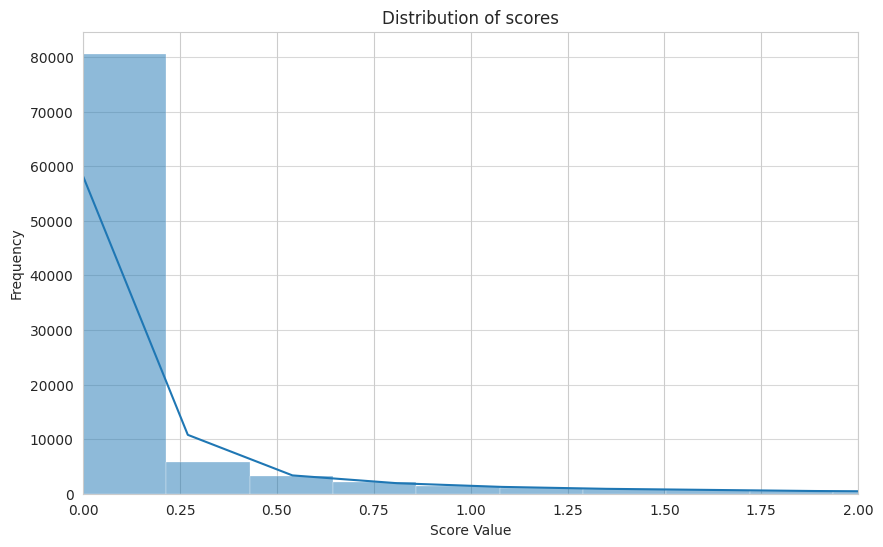

In [128]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(y_train, kde=True, bins=250)
plt.title('Distribution of scores')
plt.xlabel('Score Value')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.xlim(0, 2)
plt.show()

### Principal Component Analysis

By reducing the dataset's features to two dimensions, three clusters of points appear. The shape suggests a possibly non-linear distribution of the features.

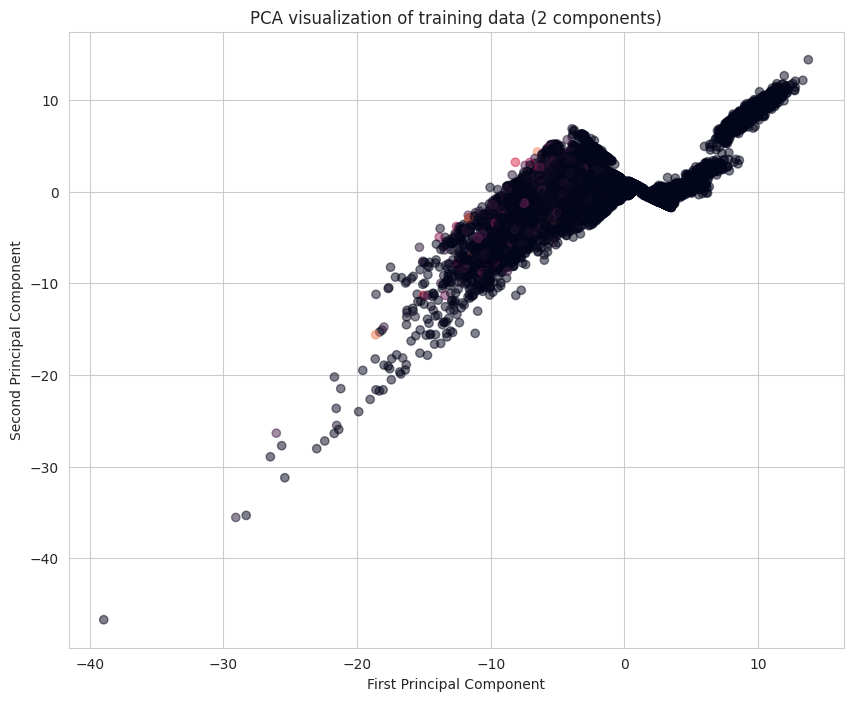

In [129]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pipeline = feature_processing(PCA(n_components=2))
pipeline.fit(X_train, y_train)
X_pca = pipeline.transform(X_train)

plt.figure(figsize=(10, 8))
plt.title('PCA visualization of training data (2 components)')
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, alpha=0.5)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

The three cells below contain utility functions which are used by all the models to plot or print the metrics.

A custom refit strategy was employed for Grid Search in order to select the model which best trades off between prediction error (Mean Squared Error) and scoring time. This strategy identifies a set of Pareto optimal estimators, where no single estimator can improve one metric without worsening the other. From this Pareto set, the estimator closest to the centroid of the Pareto points is chosen as the optimal compromise.

In [130]:
import seaborn as sns

def plot_results(results_df, pareto_front_idx, chosen_idx):
    plt.figure(figsize=(10, 6))
    ax = sns.scatterplot(data=results_df, x='mean_score_time', y='pos_mse', label='All Configurations', color='gray',
                         alpha=0.6)

    # Highlight Pareto front points (except chosen one)
    pareto_df = results_df.loc[pareto_front_idx]
    sns.scatterplot(data=pareto_df[pareto_df.index != chosen_idx], x='mean_score_time', y='pos_mse',
                    label='Pareto Front', color='#2ca25f', ax=ax)

    # Highlight chosen point
    chosen_point = results_df.loc[[chosen_idx]]
    chosen_point_label = chosen_point['config_id'].values[0]
    sns.scatterplot(data=chosen_point, x='mean_score_time', y='pos_mse', label=f'Chosen config ({chosen_point_label})',
                    color='#ff7f0e', ax=ax)
    display("Chosen params", chosen_point['params'].iloc[0])

    plt.title('Mean Score Time vs. MSE')
    plt.xlabel('Mean Score Time (s)')
    plt.ylabel('Mean Squared Error (MSE)')

    plt.grid(True, linestyle='--', alpha=0.4)

    for i in range(results_df.shape[0]):
        x = results_df['mean_score_time'].iloc[i]
        y = results_df['pos_mse'].iloc[i]
        label = results_df['config_id'].iloc[i]
        ax.annotate(str(label), (x, y), textcoords="offset points", xytext=(10, 10), ha='left', fontsize=12)

    fig = plt.gcf()
    fig.subplots_adjust(right=0.7)
    plt.tight_layout()
    plt.show()


In [131]:
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
import string, itertools

def find_minimization_pareto_front(df, x_col, y_col):
    costs = np.column_stack([df[x_col], df[y_col]])
    nds = NonDominatedSorting()
    front = nds.do(costs, only_non_dominated_front=True)
    pareto_front_idx = np.zeros(len(costs), dtype=bool)
    pareto_front_idx[front] = True
    return pareto_front_idx

double_letter = [''.join(combo) for combo in itertools.product(string.ascii_uppercase, repeat=2)]

def label_results(results_df):
    identifiers = double_letter[:results_df.shape[0]]
    results_df['config_id'] = identifiers
    return results_df

def refit_strategy(cv_results):
    results_df = pd.DataFrame(cv_results)
    results_df = label_results(results_df)

    results_df['pos_mse'] = results_df['mean_test_neg_mean_squared_error'].abs()

    # find the pareto front (best tradeoffs)
    pareto_front_indexes = find_minimization_pareto_front(results_df, 'mean_score_time', 'pos_mse')

    # find the one nearest to the centroid
    pareto_df = results_df.loc[pareto_front_indexes].copy()
    pareto_centroid = pareto_df[['mean_score_time', 'pos_mse']].mean().values
    pareto_df['distance'] = np.sqrt(
        (pareto_df['mean_score_time'] - pareto_centroid[0]) ** 2 +
        (pareto_df['pos_mse'] - pareto_centroid[1]) ** 2
    )
    pareto_df = pareto_df.sort_values(by='distance')
    idx_min = pareto_df.index[0]
    plot_results(results_df, pareto_front_indexes, idx_min)
    return idx_min

In [132]:
import pandas as pd
from IPython.display import display
metrics = pd.DataFrame()

def print_metrics(cv_results, best_index, name):
    global metrics
    mse = -cv_results['mean_test_neg_mean_squared_error'][best_index]
    rmse = -cv_results['mean_test_neg_root_mean_squared_error'][best_index]
    r2 = cv_results['mean_test_r2'][best_index]
    fit_time = cv_results['mean_score_time'][best_index]

    new_row_data = {
    'Model': name,
    'R² Score': r2,
    'MSE': mse,
    'RMSE': rmse,
    'Score Time (s)': fit_time
    }

    new_row_df = pd.DataFrame([new_row_data])
    display(f"Metrics for **{name}**", new_row_df.T)
    metrics = pd.concat([metrics, new_row_df], ignore_index=True)

## Estimators training
Grid Search CV was used for hyperparameter tuning; it systematically explores a defined range of hyperparameter values to find the combination that yields the best model performance through an exhaustive search. K-fold cross-validation is an integral part of Grid Search, where the dataset is split into k folds, and the model is trained and validated on different combinations of these folds to provide a more robust estimate of its performance. In this project, the dataset was split into 5 folds.


### Extra Trees

**Extra Trees** (or Extremely Randomized Trees) is another **ensemble learning method** that, like Random Forest, leverages multiple decision trees. However, Extra Trees introduces even greater randomness in the tree-building process. Instead of selecting the best split point for each feature, Extra Trees **randomly selects a split point** for each feature under consideration and then chooses the best among these random splits. Furthermore, each tree is built using the **entire original training dataset**, rather than bootstrap samples.

For regression tasks, the final prediction $\hat{y}$ for a new input $x$ is derived by **averaging the predictions** from all $B$ individual trees, $T_b(x)$, in the ensemble:

$$\hat{y} = \frac{1}{B} \sum_{b=1}^{B} T_b(x)$$

This increased randomness in split selection and the use of the full dataset for each tree typically leads to **lower variance** than Random Forests, potentially at the cost of a slight increase in bias. Extra Trees are often faster to train than Random Forests due to the randomized splitting process.

In [133]:
predictors = {}

To evaluate the performance of the trained regressors, the following metrics have been employed:
- the **coefficient of determination** $R^2$, which is a measure representing the proportion of variance for dependent variable that's explained by an independent variable in a regression model. It represents how well the predictions approximate real data points, with 1 being the highest and 0 the lowest;
- the **Mean Squared Error**, which measures the average difference between the estimated and the actual value. It corresponds to the expected value of the squared error loss, and serves to quantify the _average magnitude of the errors_. This metric is not expressed in same unit of measure as original data; to obtain such kind of measure, it's sufficient to take the square root, and the returned value corresponds to the RMSE.

In [134]:
scoring = ['neg_mean_squared_error', 'neg_root_mean_squared_error', 'r2'] # metrics used for model evaluation

Fitting 5 folds for each of 32 candidates, totalling 160 fits


'Chosen params'

{'regressor__predictor__max_depth': 10,
 'regressor__predictor__max_features': None,
 'regressor__predictor__min_samples_leaf': 5,
 'regressor__predictor__min_samples_split': 2,
 'regressor__predictor__n_estimators': 10,
 'regressor__predictor__random_state': 0}

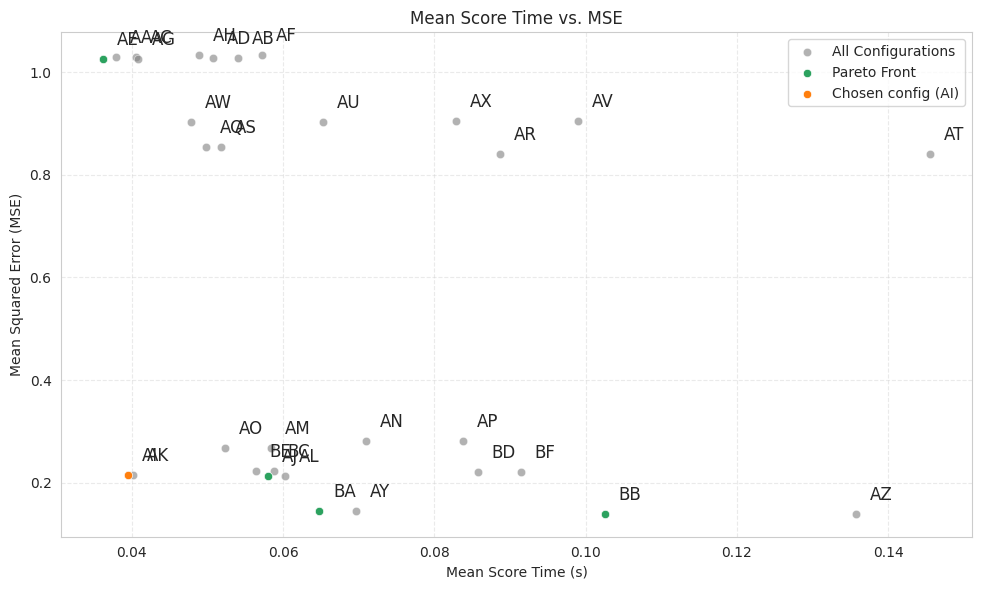

'Metrics for **ExtraTreeRegressor**'

,0
Model,ExtraTreeRegressor
R² Score,0.82962
MSE,0.215618
RMSE,0.462997
Score Time (s),0.039554


In [135]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV

params = {
    "regressor__predictor__n_estimators": [10, 20],
    "regressor__predictor__min_samples_leaf": [5, 10],
    "regressor__predictor__max_depth": [10, 20],
    "regressor__predictor__max_features": ['sqrt', None],
    "regressor__predictor__min_samples_split": [2, 5],
    "regressor__predictor__random_state": [seed],
}
et = ExtraTreesRegressor(random_state=seed)
ert_pipeline = create_pipeline(et)

gs = GridSearchCV(ert_pipeline, param_grid=params, cv=5, scoring=scoring, verbose=1, refit=refit_strategy)
gs.fit(X_train, y_train)
print_metrics(gs.cv_results_, gs.best_index_, 'ExtraTreeRegressor')
predictors['ExtraTreeRegressor'] = gs.best_estimator_

### Random Forest

**Random Forest** is an **ensemble learning method** that aggregates predictions from multiple **decision trees**. For regression, each of $B$ trees, $T_b(x)$, is built on a bootstrap sample of the training data using a random subset of features at each split. The final prediction $\hat{y}$ for a new input $x$ is the average of individual tree predictions:

$$\hat{y} = \frac{1}{B} \sum_{b=1}^{B} T_b(x)$$

This averaging reduces variance and improves robustness compared to a single decision tree.

Fitting 5 folds for each of 16 candidates, totalling 80 fits


'Chosen params'

{'regressor__predictor__max_depth': 15,
 'regressor__predictor__max_features': None,
 'regressor__predictor__min_samples_leaf': 10,
 'regressor__predictor__min_samples_split': 2,
 'regressor__predictor__n_estimators': 10,
 'regressor__predictor__random_state': 0}

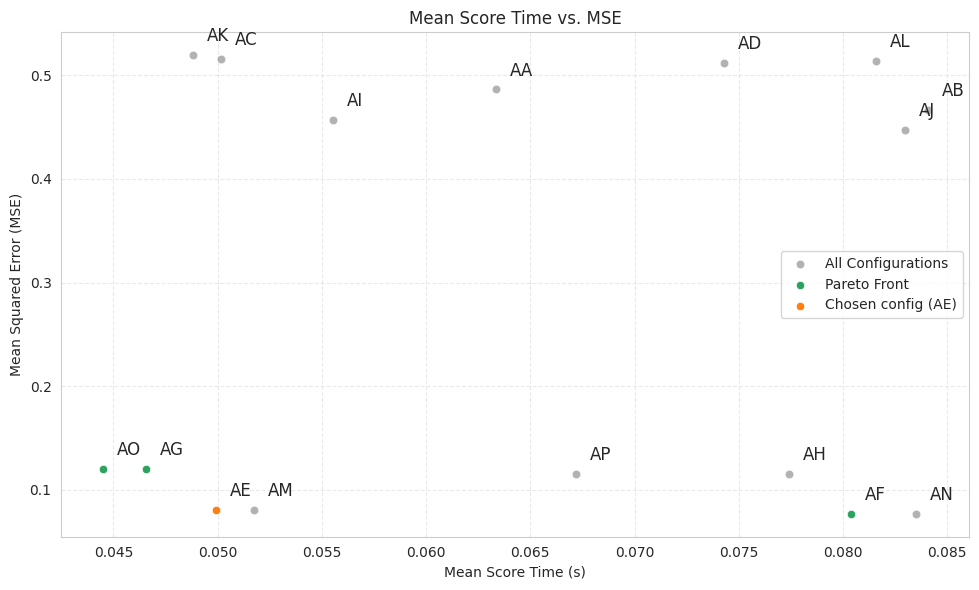

'Metrics for **RandomForestRegressor**'

,0
Model,RandomForestRegressor
R² Score,0.937185
MSE,0.080208
RMSE,0.280036
Score Time (s),0.049918


In [136]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np

params = {
    "regressor__predictor__n_estimators": [10, 20],
    "regressor__predictor__min_samples_leaf": [10, 20],
    "regressor__predictor__max_depth": [15, 20],
    "regressor__predictor__max_features": ['sqrt', None],
    "regressor__predictor__min_samples_split": [2],
    "regressor__predictor__random_state": [seed],
}
rfr = RandomForestRegressor(random_state=seed)
rfr_pipeline = create_pipeline(rfr)

gs = GridSearchCV(rfr_pipeline, param_grid=params, cv=5, scoring=scoring, verbose=1, refit=refit_strategy)
gs.fit(X_train, y_train)
print_metrics(gs.cv_results_, gs.best_index_, 'RandomForestRegressor')
predictors['RandomForestRegressor'] = gs.best_estimator_

### Decision trees

**Decision Trees** are a **supervised learning algorithm** applicable to both classification and regression tasks. For **regression**, the model constructs a tree-like structure by recursively splitting the data into subsets based on feature values. Each internal node represents a decision rule on a feature, and each branch leads to a further subset of data.

In a regression tree, each leaf node represents a **numerical outcome**. The prediction for a new data point is typically the **average (or median)** of the target values of all training samples that fall into that specific leaf node.

The primary difference from a classifier lies in the splitting criterion. Instead of metrics like Gini impurity or information gain, a Decision Tree Regressor aims to minimize the **variance or Mean Squared Error (MSE)** within each child node during the splitting process. The goal is to create homogeneous subsets where the target values are as close as possible to each other.

It's important to note that while a single Decision Tree Regressor is interpretable, it can be prone to overfitting and sensitive to small changes in the training data. This limitation is often addressed by using **ensemble methods** such as Random Forests or Gradient Boosting, which combine predictions from multiple decision trees to achieve more robust and accurate results.

Fitting 5 folds for each of 18 candidates, totalling 90 fits


'Chosen params'

{'regressor__predictor__max_depth': 20,
 'regressor__predictor__min_samples_leaf': 10,
 'regressor__predictor__min_samples_split': 2,
 'regressor__predictor__random_state': 0}

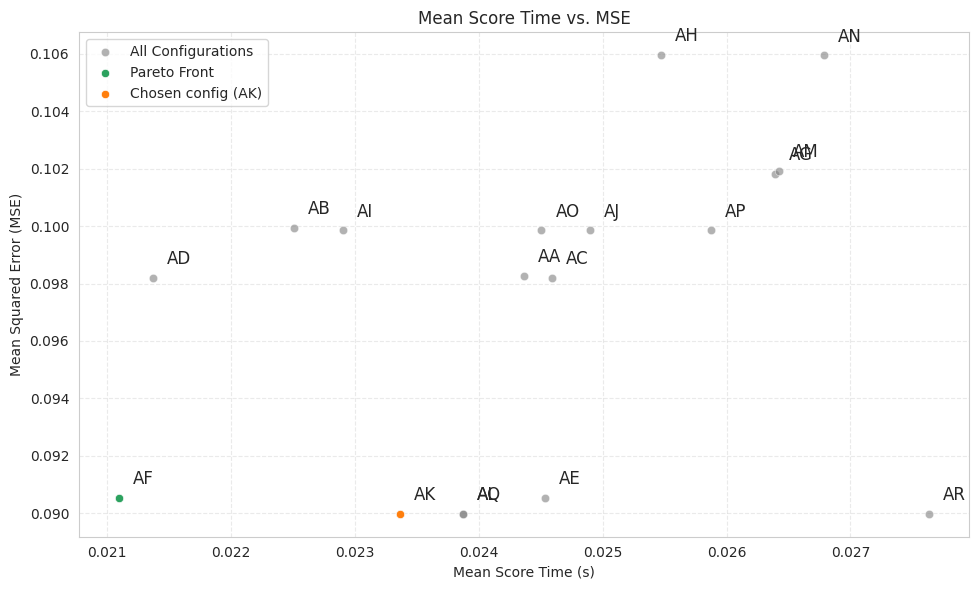

'Metrics for **DecisionTreeRegressor**'

,0
Model,DecisionTreeRegressor
R² Score,0.928575
MSE,0.089982
RMSE,0.29856
Score Time (s),0.02336


In [137]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

params = {
    "regressor__predictor__min_samples_leaf": [2, 5, 10],
    "regressor__predictor__max_depth": [10, 20, None],
    "regressor__predictor__min_samples_split": [2, 5],
    "regressor__predictor__random_state": [seed],
}

dt = DecisionTreeRegressor(random_state=seed)
dt_pipeline = create_pipeline(dt)

gs = GridSearchCV(dt_pipeline, param_grid=params, cv=5, scoring=scoring, verbose=1, refit=refit_strategy)
gs.fit(X_train, y_train)
print_metrics(gs.cv_results_, gs.best_index_, 'DecisionTreeRegressor')
predictors['DecisionTreeRegressor'] = gs.best_estimator_

### LASSO
**Lasso** incorporates **L1 regularization** into linear regression, penalizing the **absolute magnitude of coefficients**. This method promotes **sparsity** by shrinking less important feature coefficients to zero, enabling **automatic feature selection** and enhancing model interpretability.

The objective function minimized is:

$$\min_{\beta} \left( \frac{1}{2N} \sum_{i=1}^{N} (y_i - (\beta_0 + \sum_{j=1}^{P} \beta_j x_{ij}))^2 + \lambda \sum_{j=1}^{P} |\beta_j| \right)$$

Here, $\lambda$ is the regularization parameter controlling the penalty strength.

Fitting 5 folds for each of 28 candidates, totalling 140 fits


'Chosen params'

{'regressor__predictor__alpha': 0.001,
 'regressor__predictor__max_iter': 5000,
 'regressor__predictor__random_state': 0,
 'regressor__predictor__selection': 'random',
 'regressor__predictor__tol': 1e-05}

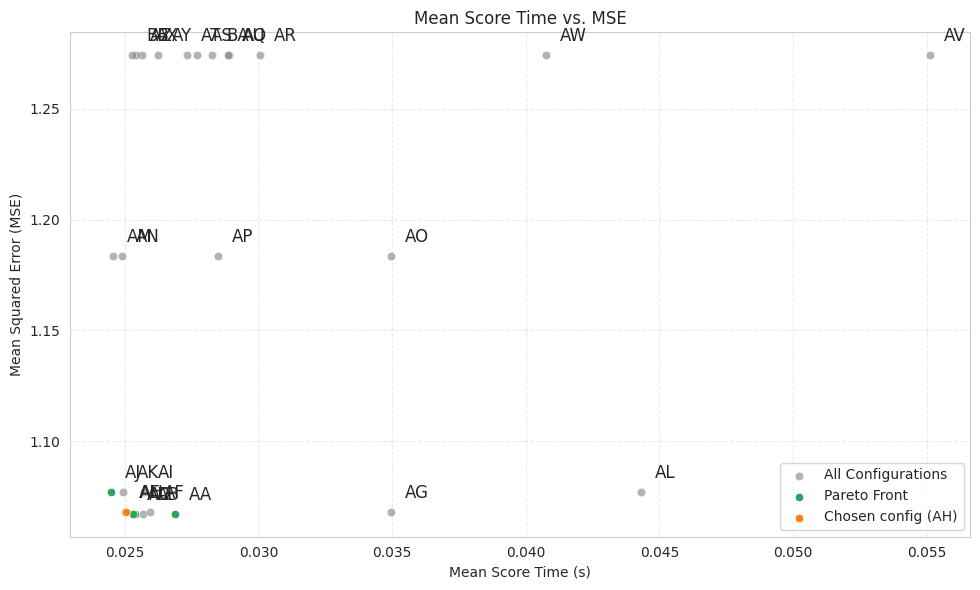

'Metrics for **Lasso**'

,0
Model,Lasso
R² Score,0.152269
MSE,1.068145
RMSE,1.032234
Score Time (s),0.025052


In [138]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

params = {
    'regressor__predictor__alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 5],
    'regressor__predictor__random_state': [seed],
    'regressor__predictor__max_iter': [5000],
    'regressor__predictor__tol': [1e-4, 1e-5],
    'regressor__predictor__selection': ['cyclic', 'random'],
}

lasso_pipeline = create_pipeline(Lasso(random_state=seed))
gs = GridSearchCV(lasso_pipeline, param_grid=params, cv=5, scoring=scoring, verbose=1, refit=refit_strategy)
gs.fit(X_train, y_train)
print_metrics(gs.cv_results_, gs.best_index_, 'Lasso')
predictors['Lasso'] = gs.best_estimator_

### Linear Regression
This model establishes a **linear relationship** between the dependent variable and one or more independent variables by fitting a straight line equation.

The loss function typically employed is the **Mean Squared Error (MSE)**, defined as:
$$J(y, \hat{y}) = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2$$


In [139]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression

lr_pipeline = create_pipeline(LinearRegression())
scores = cross_validate(lr_pipeline, X_train, y_train, cv=5, scoring=scoring)
lr_pipeline.fit(X_train, y_train)
new_row_data = {
    'Model': 'LinearRegression',
    'R² Score': np.mean(scores['test_r2']),
    'MSE': -np.mean(scores['test_neg_mean_squared_error']),
    'RMSE': -np.mean(scores['test_neg_root_mean_squared_error']),
    'Score Time (s)': np.mean(scores['score_time'])
}

new_row_df = pd.DataFrame([new_row_data])
display(new_row_df.T)
metrics = pd.concat([metrics, new_row_df], ignore_index=True)
predictors['LinearRegression'] = lr_pipeline

,0
Model,LinearRegression
R² Score,0.153211
MSE,1.066975
RMSE,1.031663
Score Time (s),0.02507


### Greedy Tree

The `GreedyTreeRegressor` class is a custom extension of scikit-learn's standard DecisionTreeRegressor. It primarily differs by adding a `complexity_` attribute (useful for the model's interpretability), which computes and stores the number of non-leaf nodes after the tree is fitted, and provides a custom string representation for the tree using feature names.

Fitting 5 folds for each of 12 candidates, totalling 60 fits


'Chosen params'

{'regressor__predictor__max_depth': 10,
 'regressor__predictor__max_features': None,
 'regressor__predictor__min_samples_leaf': 5,
 'regressor__predictor__random_state': 0}

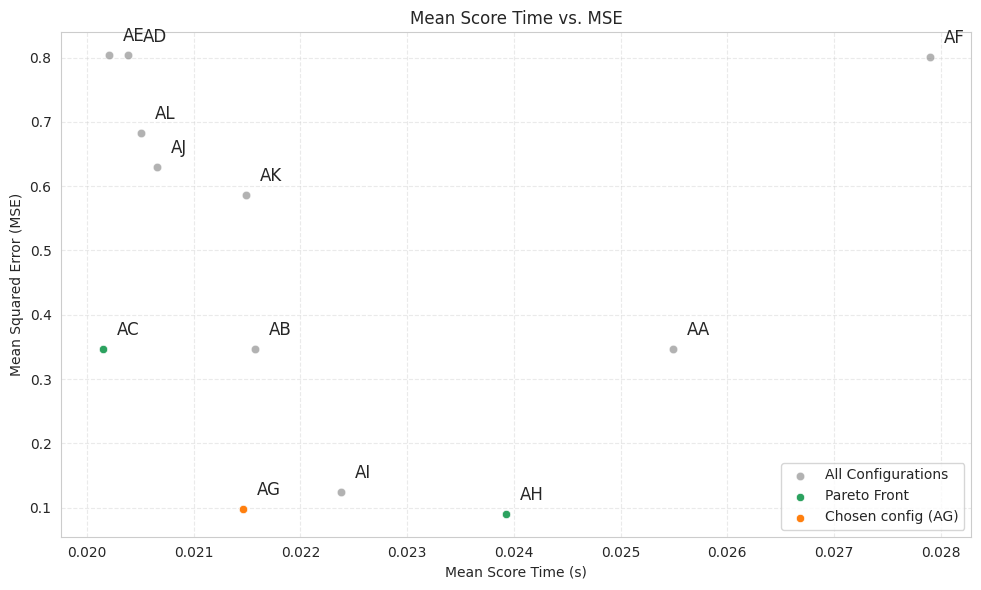

'Metrics for **GreedyTreeRegressor**'

,0
Model,GreedyTreeRegressor
R² Score,0.921463
MSE,0.098191
RMSE,0.313161
Score Time (s),0.021457


In [140]:
from imodels import GreedyTreeRegressor

params = {
    'regressor__predictor__min_samples_leaf': [5, 10, 20],
    'regressor__predictor__max_depth': [5, 10],
    'regressor__predictor__max_features': [None, 'sqrt'],
    'regressor__predictor__random_state': [seed],
}

gtr_pipeline = create_pipeline(GreedyTreeRegressor(random_state=seed))
gs = GridSearchCV(gtr_pipeline, param_grid=params, cv=5, scoring=scoring, verbose=1, refit=refit_strategy)
gs.fit(X_train, y_train)
print_metrics(gs.cv_results_, gs.best_index_, 'GreedyTreeRegressor')
predictors['GreedyTreeRegressor'] = gs.best_estimator_

### Boosted Rules

`BoostedRulesRegressor` is a an interpretable regressor optimizing simple logical rules. It uses `DecisionTreeRegressor` as an estimator with `AdaBoost`.

Fitting 5 folds for each of 12 candidates, totalling 60 fits


'Chosen params'

{'regressor__predictor__estimator__max_depth': 3,
 'regressor__predictor__estimator__min_samples_leaf': 5,
 'regressor__predictor__estimator__min_samples_split': 2,
 'regressor__predictor__estimator__random_state': 0,
 'regressor__predictor__learning_rate': 1,
 'regressor__predictor__n_estimators': 20,
 'regressor__predictor__random_state': 0}

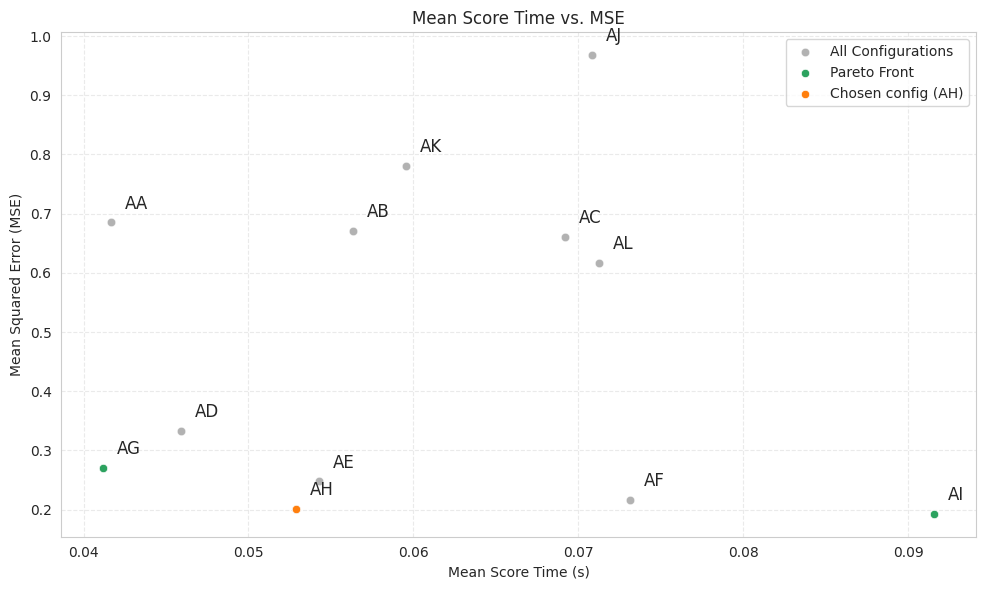

'Metrics for **BoostedRulesRegressor**'

,0
Model,BoostedRulesRegressor
R² Score,0.840519
MSE,0.201598
RMSE,0.446912
Score Time (s),0.052871


In [141]:
from imodels import BoostedRulesRegressor
params = {
    'regressor__predictor__learning_rate': [0.01, 0.5, 1, 5],
    'regressor__predictor__n_estimators': [10, 20, 30],
    'regressor__predictor__random_state': [seed],
    'regressor__predictor__estimator__max_depth': [3],
    'regressor__predictor__estimator__min_samples_leaf': [5],
    'regressor__predictor__estimator__min_samples_split': [2],
    'regressor__predictor__estimator__random_state': [seed],
}

dt = DecisionTreeRegressor(random_state=seed)
brr_pipeline = create_pipeline(BoostedRulesRegressor(random_state=seed, estimator=dt))
gs = GridSearchCV(brr_pipeline, param_grid=params, cv=5, scoring=scoring, verbose=1, refit=refit_strategy)
gs.fit(X_train, y_train)
print_metrics(gs.cv_results_, gs.best_index_, 'BoostedRulesRegressor')
predictors['BoostedRulesRegressor'] = gs.best_estimator_

### LGBMRegressor

LightGBM (Light Gradient-Boosting Machine) Regressor is a gradient boosting framework that builds decision trees **leaf-wise** for faster training and reduced memory consumption. It sequentially adds weak learners (trees) to correct residuals from previous predictions.

The final model is an additive ensemble of these trees, weighted by a learning rate:

$$\hat{y}_M(x) = \sum_{m=1}^{M} \eta h_m(x)$$

where $\hat{y}_M(x)$ is the prediction, $\eta$ is the learning rate, and $h_m(x)$ is the $m$-th tree.

Fitting 5 folds for each of 12 candidates, totalling 60 fits


'Chosen params'

{'regressor__predictor__colsample_bytree': 0.8,
 'regressor__predictor__learning_rate': 0.1,
 'regressor__predictor__max_depth': -1,
 'regressor__predictor__min_child_samples': 20,
 'regressor__predictor__min_child_weight': 0.001,
 'regressor__predictor__n_estimators': 20,
 'regressor__predictor__num_leaves': 31,
 'regressor__predictor__random_state': 0,
 'regressor__predictor__reg_alpha': 0.1,
 'regressor__predictor__reg_lambda': 0.1,
 'regressor__predictor__subsample': 0.8}

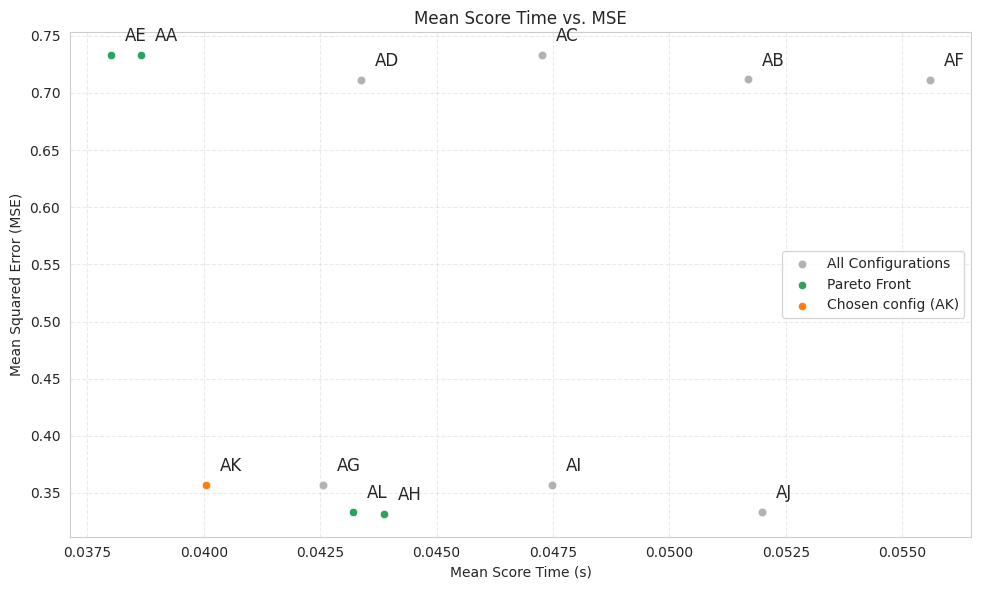

'Metrics for **LGBMRegressor**'

,0
Model,LGBMRegressor
R² Score,0.717957
MSE,0.35707
RMSE,0.59573
Score Time (s),0.040052


In [142]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

params = {
    'regressor__predictor__n_estimators': [20],
    'regressor__predictor__learning_rate': [0.05, 0.1],
    'regressor__predictor__num_leaves': [31, 63],
    'regressor__predictor__max_depth': [10, 30, -1],
    'regressor__predictor__min_child_samples': [20],
    'regressor__predictor__min_child_weight': [1e-3],
    'regressor__predictor__reg_alpha': [0.1],
    'regressor__predictor__reg_lambda': [0.1],
    'regressor__predictor__subsample': [0.8],
    'regressor__predictor__colsample_bytree': [0.8],
    'regressor__predictor__random_state': [seed]
}

lgbm_pipeline = create_pipeline(LGBMRegressor(random_state=seed, objective='regression', metric=scoring, verbose=0))
gs = GridSearchCV(lgbm_pipeline, param_grid=params, cv=5, scoring=scoring, verbose=1, refit=refit_strategy)
gs.fit(X_train, y_train)
print_metrics(gs.cv_results_, gs.best_index_, 'LGBMRegressor')
predictors['LGBMRegressor'] = gs.best_estimator_

Below the results obtained from all regressor are summarized in a table and used to create plots, useful to easily identify the best performing ones.

,Model,R² Score,MSE,RMSE,Score Time (s)
0,ExtraTreeRegressor,0.829620,0.215618,0.462997,0.039554
1,RandomForestRegressor,0.937185,0.080208,0.280036,0.049918
2,DecisionTreeRegressor,0.928575,0.089982,0.298560,0.023360
3,Lasso,0.152269,1.068145,1.032234,0.025052
4,LinearRegression,0.153211,1.066975,1.031663,0.025070
5,GreedyTreeRegressor,0.921463,0.098191,0.313161,0.021457
6,BoostedRulesRegressor,0.840519,0.201598,0.446912,0.052871
7,LGBMRegressor,0.717957,0.357070,0.595730,0.040052


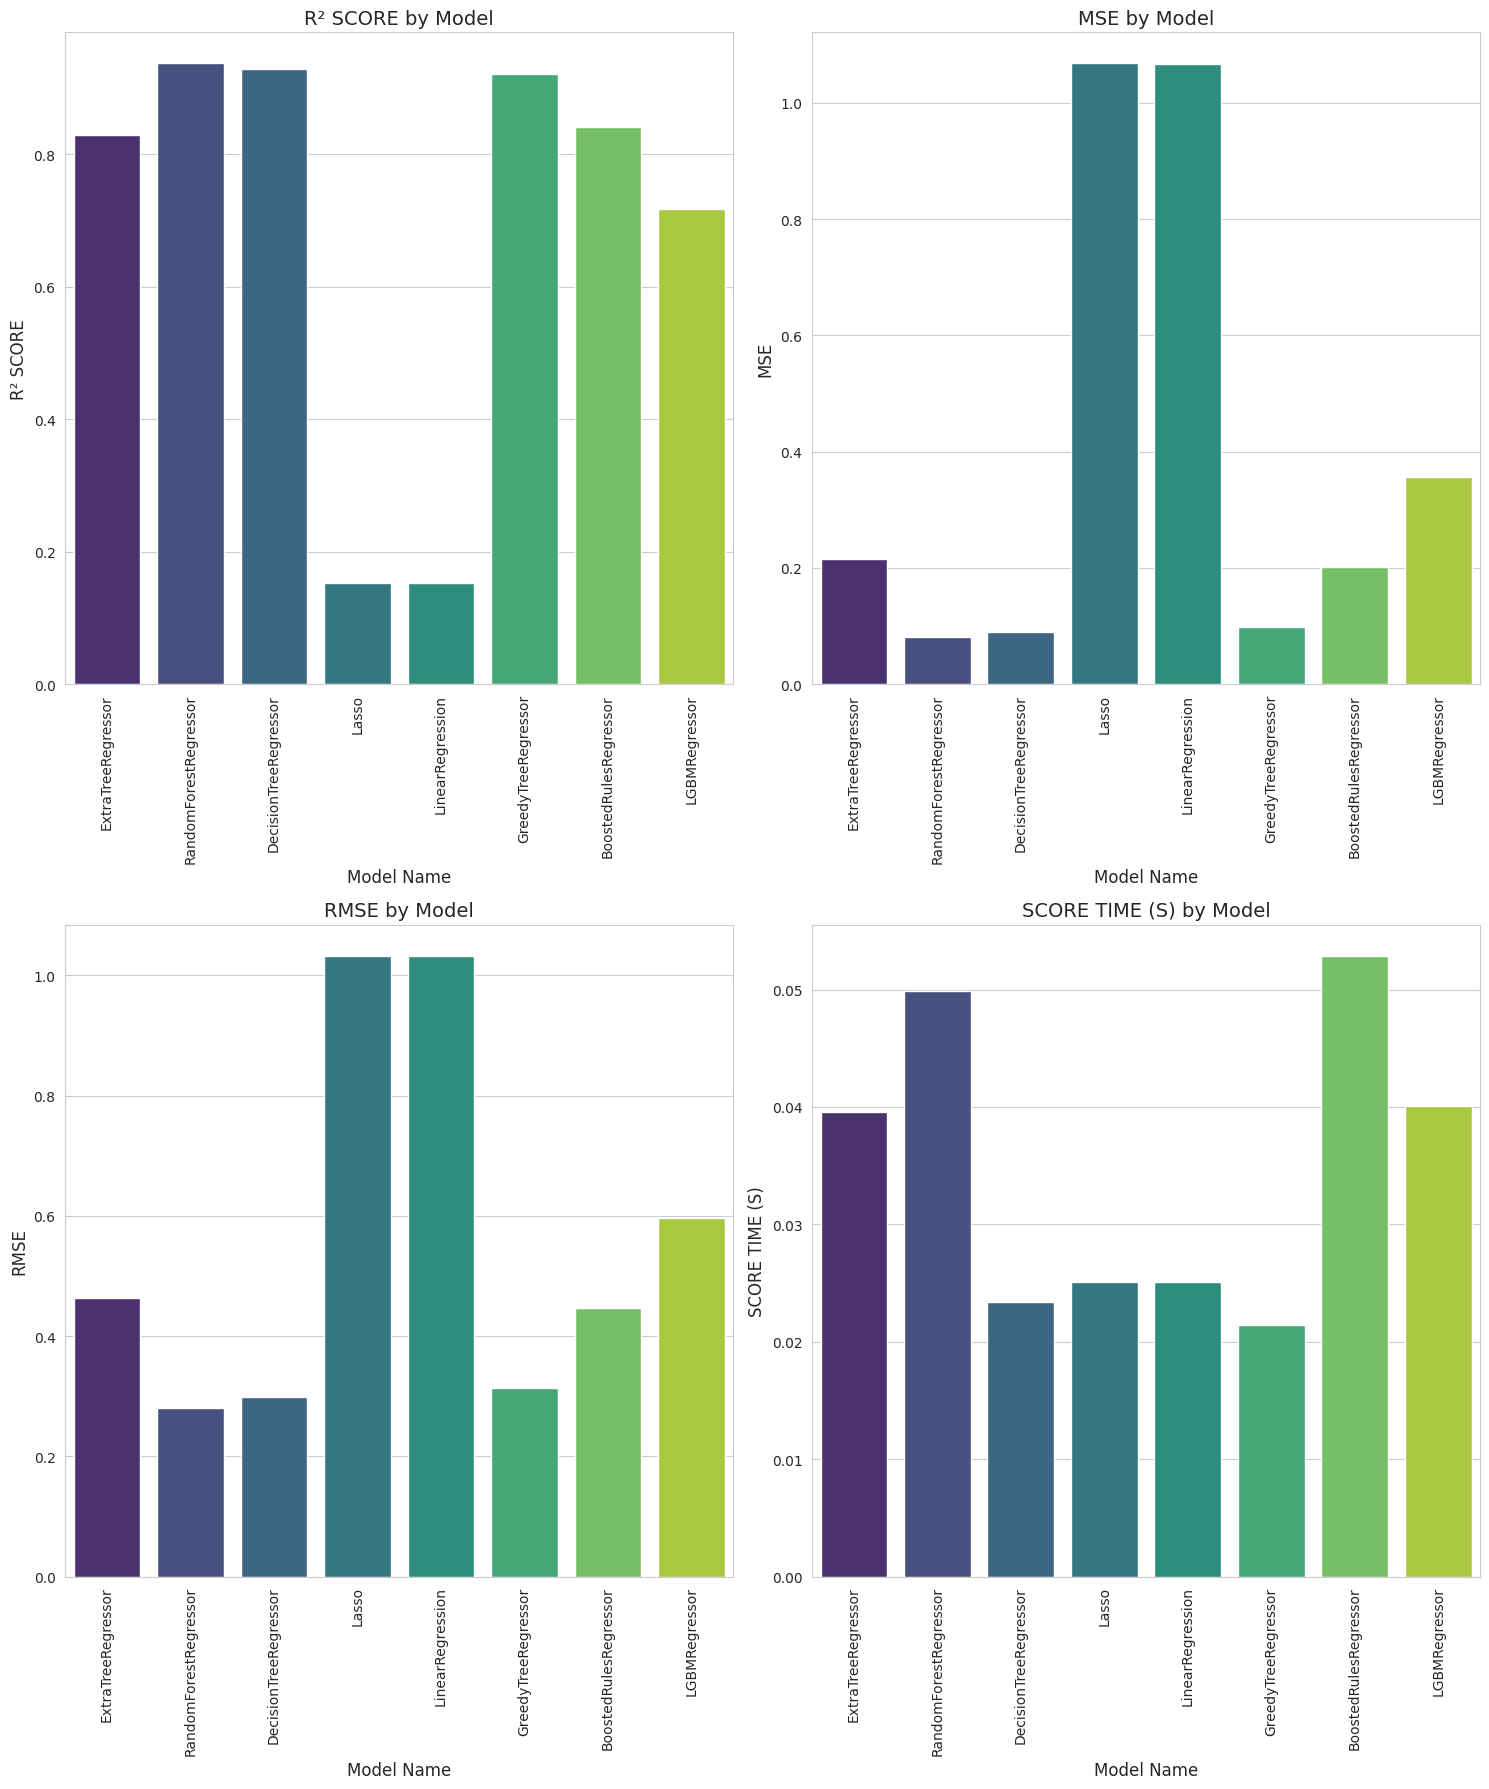

In [143]:
display(metrics)

#all metrics except name
fig, axes = plt.subplots(2, 2, figsize=(15, 18))
axes = axes.flatten()

# Plot each metric
metric_columns = [col for col in metrics.columns if col != 'Model']
for i, metric in enumerate(metric_columns):
    sns.barplot(x='Model', y=metric, data=metrics, ax=axes[i], palette='viridis')

    # Format each subplot
    axes[i].set_title(f'{metric.upper()} by Model', fontsize=14)
    axes[i].set_xlabel('Model Name', fontsize=12)
    axes[i].set_ylabel(metric.upper(), fontsize=12)
    axes[i].tick_params(axis='x', rotation=90)

# Remove the empty subplot if there is one
if len(metric_columns) < len(axes):
    fig.delaxes(axes[-1])

# Adjust layout and display
plt.tight_layout()
plt.show()

**Tree-based** models, such as Random Forest, Decision Tree, Extra Tree, and Greedy Tree Regressors, significantly **outperformed linear models** (Lasso and Linear Regression) in terms of both R-squared score and Mean Squared Error (MSE). This superior performance is primarily attributed to their ability to capture complex non-linear relationships present in the dataset, which linear models cannot effectively handle.
A RMSE value around one for Lasso and Linear Regression indicates that for most samples the predicted value is between 2 and 4 times the actual score. This result is not entirely satisfactory, although since only the relative order between scores is important to the B&B  algorithm, rather than the actual value, these models might still be useful in practice. For this reason they have been included in the benchmark phase.

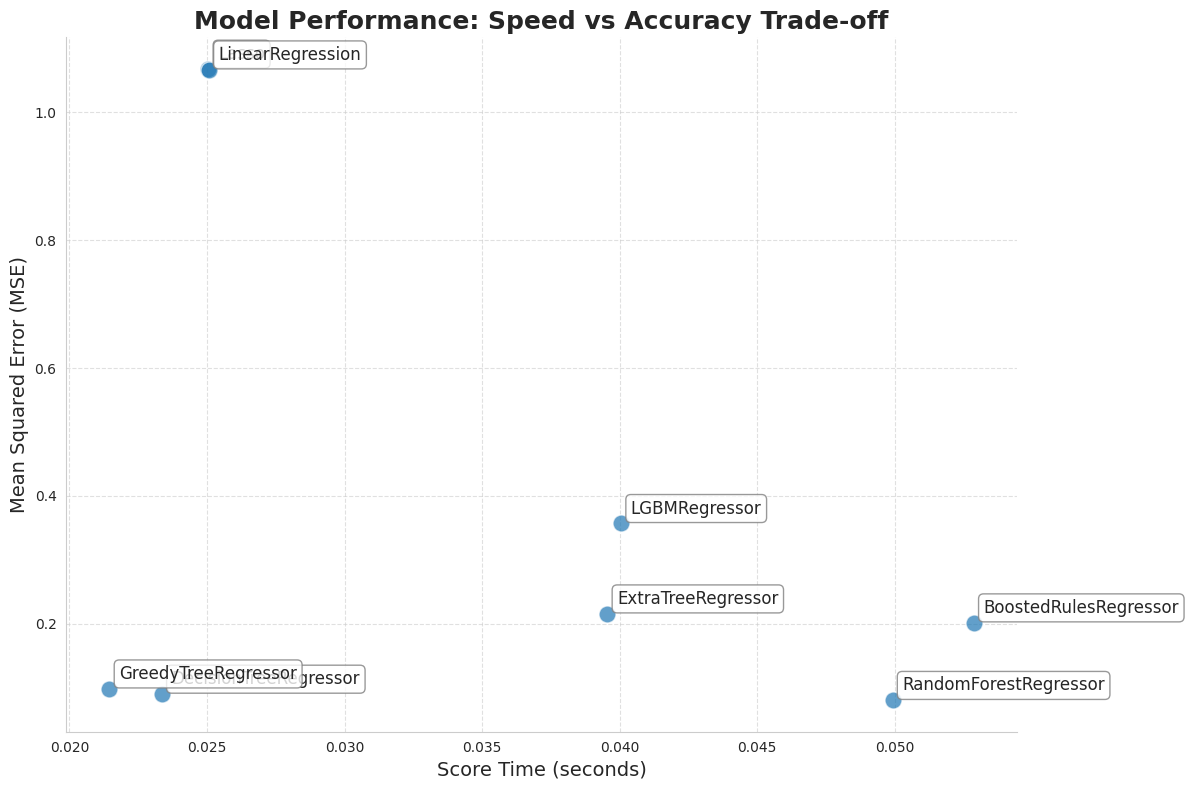

In [144]:
plt.figure(figsize=(12, 8))

ax = sns.scatterplot(
    data=metrics,
    x='Score Time (s)',
    y='MSE',
    s=150,
    alpha=0.7
)

for i, model in enumerate(metrics['Model']):
    ax.annotate(
        model,
        (metrics['Score Time (s)'].iloc[i], metrics['MSE'].iloc[i]),
        xytext=(7, 7),
        textcoords='offset points',
        fontsize=12,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
    )

sns.despine(left=False, bottom=False)

plt.title('Model Performance: Speed vs Accuracy Trade-off', fontsize=18, fontweight='bold')
plt.xlabel('Score Time (seconds)', fontsize=14)
plt.ylabel('Mean Squared Error (MSE)', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.6)
sns.set_style("whitegrid")

plt.tight_layout()
plt.show()

# Phase 3: Benchmarking

To use the predictors during the B&B algorithm, another custom branching rule (`LearnedStrongBranching`) was implemented. At each node of the tree, the features are computed and then given as input to the predictor. This returns the score which is used to determine the branching variable.

In [145]:
from pyscipopt import Model, Branchrule
from pyscipopt import SCIP_RESULT
import numpy as np
from collections import defaultdict
import pandas as pd
import math


class LearnedStrongBranching(StrongBranching):
    def __init__(self, model, predictor, A, b, c, logged, *args, **kwargs):
        super().__init__(model, A, b, c, logged, *args, **kwargs)
        self.model: Model = model
        self.predictor = predictor
        self.A = A
        self.b = b
        self.c = c
        self.logged = logged

    def branchexeclp(self, allowaddcons):
        branch_cands, branch_cand_sols, branch_cand_fracs, ncands, npriocands, nimplcands = self.model.getLPBranchCands()

        best_cand_idx = 0
        best_cand_score = float('-inf')

        for i in range(npriocands):
            self.n_branches_by_var[branch_cands[i].name] += 1
            score = self.predict_score(branch_cand_fracs[i], branch_cands[i])
            if score > best_cand_score:
                best_cand_score = score
                best_cand_idx = i

        lp_obj = self.model.getLPObjVal()
        lpsol = branch_cands[best_cand_idx].getLPSol()
        down_child, _, up_child = self.model.branchVarVal(branch_cands[best_cand_idx], branch_cand_sols[best_cand_idx])
        if down_child is not None:
            downgain = max([down_child.getLowerbound() - lp_obj, 0])
            self.down_pseudo_costs_history[branch_cands[i].name] = downgain / -self.model.frac(lpsol)
        if up_child is not None:
            upgain = max([up_child.getLowerbound() - lp_obj, 0])
            self.up_pseudo_costs_history[branch_cands[i].name] = upgain / self.model.frac(lpsol)
        self.n_branches_by_var[branch_cands[best_cand_idx].name] += 1
        new_lp_obj = self.model.getLPObjVal()
        self.objective_increases_by_var[branch_cands[best_cand_idx].name].append(abs(new_lp_obj - lp_obj))

        return {"result": SCIP_RESULT.BRANCHED}

    def predict_score(self, frac, var):
        features = self.extract_feats(frac, var)
        features = pd.DataFrame([features])
        return self.predictor.predict(pd.DataFrame(features))

A table summarizing problem statistics is extracted from the stats dataset.

In [146]:
import kagglehub, os
import pandas as pd
from IPython.display import display

stats_path = kagglehub.dataset_download("elenaferr0/strongbranchingstats")
stats_path = f"{stats_path}/Stats"
print(stats_path)
test_files = [f for f in os.listdir(stats_path) if 'test' in f]
stats_dfs = {
    f.replace("_test_stats.csv", ""): pd.read_csv(f"{stats_path}/{f}") for f in test_files
}

table_data = []
for f, stats_df in stats_dfs.items():
    stats_df['category'] = f
    table_data.append({
        "Category": f,
        "Number of problems": len(stats_df),
        "Average number of variables": int(stats_df['n_vars'].mean()),
        "Average number of constraints": int(stats_df['n_constraints'].mean()),
        "Average number of nodes": int(stats_df['n_nodes'].mean()),
        "Average time (seconds)": "{:.2f}".format(stats_df['time'].mean()),
    })

display(pd.DataFrame(table_data))

stats = {
    f: df['name'].values
    for f, df in stats_dfs.items()
}

/kaggle/input/strongbranchingstats/Stats


,Category,Number of problems,Average number of variables,Average number of constraints,Average number of nodes,Average time (seconds)
0,miplib,1,201,133,50,35.30
1,bpsc,1,112,97,42813,7873.79
2,randomSC,20,88,88,126,19.01
3,mknsc,3,201,133,47601,5882.13
4,bpeq,3,196,114,16052,1974.01
5,randomBP,22,54,14,106,17.24


Below, the problems are loaded from the LP dataset.

During the benchmark phase of the project, node limits and time limits were set. SB is the best strategy in terms of B&B tree size, so it is likely that learned strategies will perform worse size-wise, but better in terms of time.

For each problem instance, the B&B solver was allowed to explore a maximum of $10^5$ nodes and had a time limit of 3600 seconds to find a solution. If either limit was reached before optimality was proven, the solver would terminate, returning the best solution found. These are the limits suggested in the original experiment.

Given that, for time constraints, also rather small (random) problems have been considered, proportionated bounds were defined for them.

The idea of the benchmarking phase is to solve again the problems both with the learned strategy and with other standard branching strategies, to compare their performance.

In [147]:
probs_path = kagglehub.dataset_download("elenaferr0/lp-probs")
probs_path = f"{probs_path}/LP-Probs"
problems = {}
for category, names in stats.items():
    problems[category] = []
    for name in names:
        file_path = f"{probs_path}/{category}/{name}.lp"
        if os.path.exists(file_path):
            problems[category].append((file_path, name))
        else:
            print(f"Problem {name} not found in {file_path}")

branching_strategies = [
    RELIABILITY_BRANCHING,
    PSEUDO_COST_BRANCHING,
    MOST_INFEASIBLE_BRANCHING,
    RANDOM_BRANCHING,
]

short_time_limits = [-1, 0.5, 1, 5]
large_time_limits = [-1, 3600]

small_node_limits = [-1, 100, 200, 300]
large_node_limits = [-1, 10**5]

combos = {
    'randomBP': (short_time_limits, small_node_limits),
    'randomSC': (short_time_limits, small_node_limits),
    'mknsc': (large_time_limits, large_node_limits),
    'bpeq': (large_time_limits, large_node_limits),
    'bpsc': (large_time_limits, large_node_limits),
    'miplib': (large_time_limits, large_node_limits),
}

Below are some utility functions used during the benchmarking phase.

In [148]:
def load_benchmark(filename):
    if os.path.exists(filename):
        benchmark_df = pd.read_csv(filename)
        print(f"Loaded existing benchmark results with {len(benchmark_df)} rows.")
    else:
        benchmark_df = pd.DataFrame(columns=['name', 'strategy', 'time_limit', 'node_limit', 'status', 'gap', 'n_vars', 'n_constraints', 'n_nodes', 'predictor', 'category'])
    return benchmark_df

def should_skip_strategy(problem_name, strategy, time_limit, node_limit, benchmark_df, cache):
    in_benchmark = benchmark_df[
        (benchmark_df['name'] == problem_name) &
        (benchmark_df['strategy'] == strategy) &
        (benchmark_df['time_limit'] == time_limit) &
        (benchmark_df['node_limit'] == node_limit)
    ].shape[0] > 0

    in_cache = cache.get((problem_name, strategy), False)
    return in_benchmark or in_cache

def should_skip_predictor(problem_name, predictor, time_limit, node_limit, benchmark_df, cache):
    in_benchmark = benchmark_df[
        (benchmark_df['name'] == problem_name) &
        (benchmark_df['predictor'] == predictor) &
        (benchmark_df['time_limit'] == time_limit) &
        (benchmark_df['node_limit'] == node_limit)
    ].shape[0] > 0

    in_cache = cache.get((problem_name, predictor), False)
    return in_benchmark or in_cache

def load_cache(benchmark_df):
    solved_optimally_cache = defaultdict(bool)
    for index, row in benchmark_df.iterrows():
        key = (row['name'], row['strategy'])
        if row['status'] == 'optimal':
            solved_optimally_cache[key] = True
        else:
            solved_optimally_cache[key] = False
    return solved_optimally_cache

def store_benchmark_row(benchmark_df, filename, row):
    pdata = pd.DataFrame.from_dict(row, orient='index').T
    benchmark_df = pd.concat([benchmark_df, pdata], ignore_index=True)
    benchmark_df.to_csv(filename, index=False)
    return benchmark_df

Two benchmarks have been done:
- the strategies benchmark, which solves problems with the following branching strategies: reliability branching, pseudo cost branching, most infeasible branching and random branching;

- predictor's benchmark: which solves problems using the predictors.

In [149]:
def strategies_benchmark(out_dir):
    strategies_benchmark_df = load_benchmark(f"{out_dir}/strategies_benchmark.csv")
    solved_optimally_cache = load_cache(strategies_benchmark_df)

    for category, probs in problems.items():
        time_limits, node_limits = combos.get(category, (large_time_limits, large_node_limits))

        for filepath, name in probs:
            prob = Problem.from_model(filepath, name)
            for strategy in branching_strategies:
                achieved_optimality = False

                for time_limit in time_limits:
                    for node_limit in node_limits:
                        # either node limit or timelimit must be set to -1, not both, not none
                        if time_limit == -1 and node_limit == -1:
                            continue
                        if time_limit != -1 and node_limit != -1:
                            continue

                        if should_skip_strategy(prob.name, strategy, time_limit, node_limit, strategies_benchmark_df, solved_optimally_cache):
                            print(f"Skipping {prob.name} with strategy {strategy}, time limit {time_limit}, and node limit {node_limit} (already benchmarked or cached)")
                            continue

                        print(f"Solving {prob.name} with strategy {strategy}, time limit {time_limit}, and node limit {node_limit}")
                        row = prob.solve_with_rule(strategy, logged=True, max_nodes=node_limit, timelimit=time_limit)
                        row['category'] = category
                        strategies_benchmark_df = store_benchmark_row(strategies_benchmark_df, f"{out_dir}/strategies_benchmark.csv", row)

                        if row['status'] == 'optimal':
                            solved_optimally_cache[(prob.name, strategy)] = True
                            achieved_optimality = True
                            break # exit node_limits loop

                    if achieved_optimality:
                        break # exit time_limits loop

            prob.model.freeProb()



In [150]:
def predictors_benchmark(out_dir):
    predictors_benchmark_df = load_benchmark(f"{out_dir}/predictors_benchmark.csv")
    solved_optimally_cache = load_cache(predictors_benchmark_df)

    for category, probs in problems.items():
        # Get the specific time and node limits for this category
        time_limits, node_limits = combos.get(category, (large_time_limits, large_node_limits))
        print("Category:", category, "Time limits:", time_limits, "Node limits:", node_limits)
        for predictor_name, predictor_instance in predictors.items():
            for filepath, name in probs:
                prob = Problem.from_model(filepath, name)
                achieved_optimality = False

                for time_limit in time_limits:
                    for node_limit in node_limits:
                        # Skip invalid combinations - either time limit or node limit must be set
                        if time_limit == -1 and node_limit == -1:
                            continue
                        if time_limit != -1 and node_limit != -1:
                            continue

                        if should_skip_predictor(prob.name, predictor_name, time_limit, node_limit, predictors_benchmark_df, solved_optimally_cache):
                            print(f"Skipping {prob.name} with predictor {predictor_name}, time limit {time_limit}, and node limit {node_limit} (already benchmarked or cached)")
                            continue

                        print(f"Solving {prob.name} with predictor {predictor_name}, time limit {time_limit}, and node limit {node_limit}")
                        row = prob.solve_with_rule(
                            LEARNED_STRONG_BRANCHING,
                            predictor=predictor_instance,
                            predictor_name=predictor_name,
                            logged=False,
                            max_nodes=node_limit,
                            timelimit=time_limit
                        )
                        row['category'] = category
                        predictors_benchmark_df = store_benchmark_row(predictors_benchmark_df, f"{out_dir}/predictors_benchmark.csv", row)

                        if row['status'] == 'optimal':
                            solved_optimally_cache[(prob.name, predictor_name)] = True
                            achieved_optimality = True
                            break  # exit node_limits loop

                    if achieved_optimality:
                        break  # exit time_limits loop

                prob.model.freeProb()

Again, given the computational burden of solving them, the pre-populated dataset of benchmarks is imported from Kaggle (https://www.kaggle.com/datasets/elenaferr0/strongbranchingbenchmarks)

In [151]:
import kagglehub, os

benchmark_dir = kagglehub.dataset_download("elenaferr0/strongbranchingbenchmarks")
if os.listdir(benchmark_dir) == 0:
    benchmarks_dir = "."
    strategies_benchmark(out_dir=benchmarks_dir)
    predictors_benchmark(out_dir=benchmarks_dir)


## Strong Branching vs other learning strategies

In the cells below, some aggregations are performed with the extracted data, so to compare the original SB performances with learned strong branching and with standard branching strategies.

Columns named `*_stats` refer to data extracted with the SB strategy, while the ones named `*_bench` refer to those computed by benchmarks. All reduction and increase columns below are expressed in percentage.

A column with the time increase and node decrease of each strategy with respect to the original SB is shown.

In [152]:
from IPython.display import display

benchmarks = pd.concat([
    pd.read_csv(f"{benchmark_dir}/strategies_benchmark.csv"),
    pd.read_csv(f"{benchmark_dir}/predictors_benchmark.csv")
], ignore_index=True)

small_benchmarks = benchmarks[
    (benchmarks['category'] == 'randomBP') |
    (benchmarks['category'] == 'randomSC')
].copy()

large_benchmarks = benchmarks[
    (benchmarks['category'] == 'mknsc') |
    (benchmarks['category'] == 'bpeq') |
    (benchmarks['category'] == 'bpsc') |
    (benchmarks['category'] == 'miplib')
].copy()

def aggregate_benchmarks_by_strategy(bench_df):
    reference_stats = pd.concat(stats_dfs.values(), ignore_index=True)

    # Create a mapping from problem name to its reference values
    reference_map = {}
    for _, row in reference_stats.iterrows():
        reference_map[row['name']] = {
            'stats_nodes': row['n_nodes'],
            'stats_time': row['time'],
            'stats_vars': row['n_vars'],
            'stats_constraints': row['n_constraints'],
            'category': row['category'],
            'strategy': 'strongbranching'
        }

    # Create a new dataframe with benchmarks plus reference values
    enhanced_data = []
    for _, row in bench_df.iterrows():
        if row['name'] not in reference_map:
            continue

        ref = reference_map[row['name']]

        enhanced_row = {
            'strategy': row['strategy'],
            'predictor': row['predictor'] if 'predictor' in row and pd.notna(row['predictor']) else None,
            'category': row['category'],
            'name': row['name'],
            'n_nodes_bench': row['n_nodes'],
            'time_bench': row['time'],
            'gap_bench': row['gap'],
            'n_nodes_stats': ref['stats_nodes'],
            'time_stats': ref['stats_time'],
            'n_vars_stats': ref['stats_vars'],
            'n_constraints_stats': ref['stats_constraints']
        }
        enhanced_data.append(enhanced_row)

    enhanced_df = pd.DataFrame(enhanced_data)

    enhanced_df['time_reduction'] = ((enhanced_df['time_stats'] - enhanced_df['time_bench']) /
                                      enhanced_df['time_stats']) * 100
    enhanced_df['nodes_increase'] = ((enhanced_df['n_nodes_bench'] - enhanced_df['n_nodes_stats']) /
                                     enhanced_df['n_nodes_stats']) * 100

    agg_df = enhanced_df.groupby(['strategy']).agg({
        'n_nodes_bench': 'mean',
        'time_bench': 'mean',
        'gap_bench': 'mean',
        'n_nodes_stats': 'mean',
        'time_stats': 'mean',
        'n_vars_stats': 'mean',
        'n_constraints_stats': 'mean',
        'time_reduction': 'mean',
        'nodes_increase': 'mean',
        'name': 'count'
    }).reset_index()

    agg_df = agg_df.rename(columns={'name': 'solved_instances'})
    return agg_df

# Process small benchmarks
small_results = aggregate_benchmarks_by_strategy(small_benchmarks)
display("Small Benchmarks (randomBP, randomSC) - Performance by Strategy:", small_results)

# Process large benchmarks
large_results = aggregate_benchmarks_by_strategy(large_benchmarks)
display("Large Benchmarks (mknsc, bpeq, bpsc, miplib) - Performance by Strategy:", large_results)

# Additionally show non-optimally solved counts
group_non_optimally_solved_small = (small_benchmarks[small_benchmarks['status'] != 'optimal']
    .groupby(['strategy']).size().reset_index(name='non_optimal_solved'))
display("Count of Non-Optimally Solved Small Problems:", group_non_optimally_solved_small)

group_non_optimally_solved_large = (large_benchmarks[large_benchmarks['status'] != 'optimal']
    .groupby(['strategy']).size().reset_index(name='non_optimal_solved'))
display("Count of Non-Optimally Solved Large Problems:", group_non_optimally_solved_large)

'Small Benchmarks (randomBP, randomSC) - Performance by Strategy:'

,strategy,n_nodes_bench,time_bench,gap_bench,n_nodes_stats,time_stats,n_vars_stats,n_constraints_stats,time_reduction,nodes_increase,solved_instances
0,learnedstrongbrnch,153.919543,7.717844,0.404042,110.856863,18.536129,72.156835,52.647482,57.537283,102.621500,695
1,mostinf,159.450758,7.727990,0.397456,112.497273,18.089986,69.068182,46.670455,56.552938,108.674065,88
2,pscost,160.096296,7.823590,0.415214,115.898667,17.892652,67.988889,44.633333,56.814968,75.215533,90
3,random,169.280488,8.119749,0.398825,110.285854,17.414776,67.463415,42.524390,53.361248,100.536326,82
4,relpscost,162.748858,5.933811,0.321713,123.274521,18.523974,70.931507,48.630137,67.111007,72.457689,73


'Large Benchmarks (mknsc, bpeq, bpsc, miplib) - Performance by Strategy:'

,strategy,n_nodes_bench,time_bench,gap_bench,n_nodes_stats,time_stats,n_vars_stats,n_constraints_stats,time_reduction,nodes_increase,solved_instances
0,learnedstrongbrnch,57845.792408,1889.706370,0.389898,30848.979592,4173.120638,187.714286,122.387755,0.064101,178.483645,98
1,mostinf,62373.833333,1660.214792,0.385546,29663.500000,3723.852001,183.750000,119.416667,25.853209,209.918158,12
2,pscost,59125.454545,875.680417,0.220965,30329.909091,4266.195594,192.181818,123.818182,64.178824,228.599174,11
3,random,58258.000000,3462.309460,0.448142,33796.769231,4675.035687,186.000000,122.076923,36.086132,140.806398,13
4,relpscost,51759.666667,1392.170307,0.285890,26169.833333,3028.746607,191.416667,123.916667,-3.007411,177.109822,12


'Count of Non-Optimally Solved Small Problems:'

,strategy,non_optimal_solved
0,learnedstrongbrnch,366
1,mostinf,47
2,pscost,50
3,random,40
4,relpscost,31


'Count of Non-Optimally Solved Large Problems:'

,strategy,non_optimal_solved
0,learnedstrongbrnch,65
1,mostinf,8
2,pscost,3
3,random,10
4,relpscost,5


As expected, all strategies are quite faster than the original SB one, with solution time being from $10\%$ to $61\%$ shorter.

Alvarez et al. obtained an $85\%$ decrease in solving time, hence all the trained predictors actually perform worse than the original experiment's benchmarks.

 Furthermore, the number of nodes increased by around $80\%$ for small problems and over $170\%$ for bigger ones. This percentage is rather high and roughly aligned with other branching strategies' increases; this suggests that the learned branching strategy is not excellent at reducing the tree size, but is at least slightly better than random and most infeasible branching; given the nature of these, this is rather reasonable.






## Improvements grouped by branching strategy

In [153]:
def merge_benchmarks(benchmarks_grouped, stats_grouped):
    merged_df = pd.merge(stats_grouped, benchmarks_grouped, on='category', how='outer')
    merged_df['time_reduction'] = (
        (merged_df['time_stats'] - merged_df['time_bench']) / merged_df['time_stats']
    ) * 100
    merged_df['nodes_increase'] = (
        (merged_df['n_nodes_bench'] - merged_df['n_nodes_stats']) / merged_df['n_nodes_stats']
    ) * 100

    # reorder
    order = ['category', 'n_vars_stats', 'n_constraints_stats', 'n_nodes_stats', 'n_nodes_bench', 'nodes_increase',
            'time_stats', 'time_bench', 'time_reduction']

    if merged_df.columns.str.contains('gap_bench').any():
        order += ['gap_bench']
    merged_df = merged_df[order]

    for col in merged_df.columns:
        if 'time' in col or 'gap' in col or 'nodes' in col:
            merged_df[col] = merged_df[col].apply(lambda x: f'{x:.2f}' if pd.notnull(x) else x)
    # remove any NaN rows
    return merged_df.dropna()


categories = ['randomBP', 'randomSC', 'mknsc', 'bpeq', 'bpsc', 'miplib']

# concat all keys of stats_dfs into a single DataFrame
stats = pd.concat(stats_dfs.values(), ignore_index=True)
stats_grouped = stats.groupby(['category']).agg({
    'n_vars': 'mean',
    'n_constraints': 'mean',
    'n_nodes': 'mean',
    'time': 'mean',
}).reset_index()
stats_grouped = stats_grouped.rename(columns=lambda x: f'{x}_stats' if x != 'category' else x)


optimally_solved_bench = benchmarks[benchmarks['status'] == 'optimal']
non_optimally_solved_bench = benchmarks[benchmarks['status'] != 'optimal']

optimally_solved_bench = optimally_solved_bench.groupby(['category']).agg({
    'n_nodes': 'mean',
    'time': 'mean',
}).reset_index()

non_optimally_solved_bench = non_optimally_solved_bench.groupby(['category']).agg({
    'n_nodes': 'mean',
    'time': 'mean',
    'gap': 'mean',
}).reset_index()

optimally_solved_bench = optimally_solved_bench.rename(columns=lambda x: f'{x}_bench' if x != 'category' else x)
non_optimally_solved_bench = non_optimally_solved_bench.rename(columns=lambda x: f'{x}_bench' if x != 'category' else x)

optimally_solved_agg = merge_benchmarks(optimally_solved_bench, stats_grouped)
print("Optimally solved benchmarks:")
display(optimally_solved_agg)
non_optimally_solved_agg = merge_benchmarks(non_optimally_solved_bench, stats_grouped)
print("Non-optimally solved benchmarks:")
display(non_optimally_solved_agg)

Optimally solved benchmarks:


,category,n_vars_stats,n_constraints_stats,n_nodes_stats,n_nodes_bench,nodes_increase,time_stats,time_bench,time_reduction
0,bpeq,196.333333,114.666667,16052.33,45900.92,185.95,1974.01,1072.58,45.67
1,bpsc,112.000000,97.000000,42813.00,58807.03,37.36,7873.79,2694.33,65.78
2,miplib,201.000000,133.000000,50.00,100.34,100.68,35.30,18.52,47.52
3,mknsc,201.000000,133.666667,47601.67,68946.70,44.84,5882.13,1858.68,68.40
4,randomBP,54.636364,14.772727,106.09,134.86,27.11,17.24,7.69,55.41
5,randomSC,88.800000,88.800000,126.79,216.68,70.89,19.01,8.36,56.02


Non-optimally solved benchmarks:


,category,n_vars_stats,n_constraints_stats,n_nodes_stats,n_nodes_bench,nodes_increase,time_stats,time_bench,time_reduction,gap_bench
0,bpeq,196.333333,114.666667,16052.33,71485.19,345.33,1974.01,1888.45,4.33,0.74
1,bpsc,112.000000,97.000000,42813.00,73696.34,72.14,7873.79,3777.20,52.03,0.81
3,mknsc,201.000000,133.666667,47601.67,77022.19,61.81,5882.13,2879.46,51.05,0.73
4,randomBP,54.636364,14.772727,106.09,137.68,29.77,17.24,6.82,60.42,0.76
5,randomSC,88.800000,88.800000,126.79,145.32,14.62,19.01,7.79,59.03,0.77


The tables above show the increase in size and decrease in resolution time of problems grouped by category, both optimally and non-optimally solved respectively. `bpeq` and `miplib` problems are the one suffering from the worst nodes increase, likely because their scale amplifies the impact of suboptimal branching decisions.

The gaps for non-optimally solved problems are slightly higher than the ones obtained by Alvarez, implying that the problems were further from the optimal solution when either the node or the time limit was reached.

## Improvements by predictor

In [154]:
reference_stats = pd.concat(stats_dfs.values(), ignore_index=True)

reference_map = {}
for _, row in reference_stats.iterrows():
    reference_map[row['name']] = {
        'stats_nodes': row['n_nodes'],
        'stats_time': row['time']
    }

problem_metrics = []
for _, row in benchmarks.iterrows():
    if row['name'] not in reference_map:
        continue

    stats_data = reference_map[row['name']]

    nodes_increase = ((row['n_nodes'] - stats_data['stats_nodes']) / stats_data['stats_nodes']) * 100 if stats_data['stats_nodes'] > 0 else float('inf')
    time_decrease = ((stats_data['stats_time'] - row['time']) / stats_data['stats_time']) * 100 if stats_data['stats_time'] > 0 else float('inf')

    metrics_row = row.to_dict()
    metrics_row['nodes_increase'] = nodes_increase
    metrics_row['time_decrease'] = time_decrease

    problem_metrics.append(metrics_row)

problem_df = pd.DataFrame(problem_metrics)
group_by_predictor = problem_df.groupby(['predictor']).agg({
    'nodes_increase': 'mean',
    'time_decrease': 'mean',
    'gap': 'mean',
}).reset_index()
display(group_by_predictor)

,predictor,nodes_increase,time_decrease,gap
0,BoostedRulesRegressor,96.084255,52.382073,0.419832
1,DecisionTreeRegressor,93.992334,54.567225,0.394968
2,ExtraTreeRegressor,95.472059,44.096896,0.417176
3,GreedyTreeRegressor,112.968428,48.418222,0.359203
4,LGBMRegressor,105.813081,47.845831,0.391089
5,Lasso,159.987352,56.307795,0.419195
6,LinearRegression,126.250134,55.170032,0.428828
7,RandomForestRegressor,104.268824,44.138840,0.381663


The table above summarizes results obtained by using each estimator to predict branching scores. Tree-based models are in general performing better than linear ones size-wise, however with regards to time, linear model predictions tend to be faster, thus producing a bigger decrease.

This is consistent with the results of the learning phase.